# Imports

In [214]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from keras.layers import Input, Dense
from keras.models import Model
from enum import Enum
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# Preprocessing

The mozilla_core.csv must be downloaded and placed in the same directory as this file in order for the code to work

Loading csv file

In [4]:
dataset = pd.read_csv('mozilla_core.csv')
dataset['Text'] = dataset['Title'] + ' ' + dataset['Description']
dataset = dataset[['Issue_id', 'Text', 'Component']]
dataset['Text'] = dataset['Text'].astype(str)
dataset.head(6)

,Issue_id,Text,Component
0,91,document properties cannot be listed Created b...,DOM: Core & HTML
1,103,layout bug: table cell overflows containing ce...,Layout: Tables
2,104,table saved as text: missing inter-column spac...,Serializers
3,105,nested <TABLE>s: bgcolor of inner table not re...,Layout: Tables
4,133,Navigator draws entities like &lt;&amp;&gt; as...,Internationalization
5,134,Navigator crashes w/ javascript setting textar...,JavaScript Engine


Removing code from the text

In [5]:
def remove_code_snippets(description):
    """
    Removes code snippets from the bug description.
    """
    # Regular expression to identify code snippets.
    # This example is simplistic; you might need a more sophisticated pattern.
    code_pattern = re.compile(
        r'''
        # Match inline code within backticks
        (`[^`]*`) |
        # Match code-like patterns with special characters (e.g., <>, {}, [])
        (\{[^}]*\}) | (\[[^\]]*\]) | (\([^)]*\)) | (<[^>]*>) |
        # Match common keywords in code-like patterns
        (\bif\b|\belse\b|\bwhile\b|\bfor\b|\breturn\b|\bimport\b|\bclass\b|\bdef\b|\bpublic\b|\bprivate\b|\bprotected\b|\bstatic\b|\bvoid\b|\bint\b|\bString\b|\bnew\b)
        ''',
        re.VERBOSE
    )

    # Remove the code snippets
    cleaned_description = re.sub(code_pattern, '', description)
    return cleaned_description.strip()

# Apply the function to the descriptions column
dataset['Cleaned_Text'] = dataset['Text'].apply(remove_code_snippets)
dataset.head(6)

,Issue_id,Text,Component,Cleaned_Text
0,91,document properties cannot be listed Created b...,DOM: Core & HTML,document properties cannot be listed Created b...
1,103,layout bug: table cell overflows containing ce...,Layout: Tables,layout bug: table cell overflows containing ce...
2,104,table saved as text: missing inter-column spac...,Serializers,table saved as text: missing inter-column spac...
3,105,nested <TABLE>s: bgcolor of inner table not re...,Layout: Tables,nested s: bgcolor of inner table not recognize...
4,133,Navigator draws entities like &lt;&amp;&gt; as...,Internationalization,Navigator draws entities like &lt;&amp;&gt; as...
5,134,Navigator crashes w/ javascript setting textar...,JavaScript Engine,Navigator crashes w/ javascript setting textar...


Removing numbers and special characters, and changing to lower-case

In [6]:
def clean_text(text):
    # Remove all numbers and special characters
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert all letters to lowercase
    cleaned_text = cleaned_text.lower()
    return cleaned_text

# Example usage
dataset['Cleaned_Text'] = dataset['Cleaned_Text'].apply(clean_text)
dataset.head(6)

,Issue_id,Text,Component,Cleaned_Text
0,91,document properties cannot be listed Created b...,DOM: Core & HTML,document properties cannot be listed created b...
1,103,layout bug: table cell overflows containing ce...,Layout: Tables,layout bug table cell overflows containing cel...
2,104,table saved as text: missing inter-column spac...,Serializers,table saved as text missing intercolumn space ...
3,105,nested <TABLE>s: bgcolor of inner table not re...,Layout: Tables,nested s bgcolor of inner table not recognized...
4,133,Navigator draws entities like &lt;&amp;&gt; as...,Internationalization,navigator draws entities like ltampgt as s whe...
5,134,Navigator crashes w/ javascript setting textar...,JavaScript Engine,navigator crashes w javascript setting textare...


Removing stop words

In [7]:
nltk.download('stopwords')

def remove_stop_words(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Get English stop words
    stop_words = set(stopwords.words('english'))
    # Filter out the stop words
    filtered_text = [word for word in tokens if word not in stop_words]
    # Join the filtered words back into a string
    filtered_text = ' '.join(filtered_text)
    return filtered_text

dataset['Cleaned_Text'] = dataset['Cleaned_Text'].apply(remove_stop_words)
dataset.head(6)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabgilp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Issue_id,Text,Component,Cleaned_Text
0,91,document properties cannot be listed Created b...,DOM: Core & HTML,document properties listed created till krech ...
1,103,layout bug: table cell overflows containing ce...,Layout: Tables,layout bug table cell overflows containing cel...
2,104,table saved as text: missing inter-column spac...,Serializers,table saved text missing intercolumn space cre...
3,105,nested <TABLE>s: bgcolor of inner table not re...,Layout: Tables,nested bgcolor inner table recognized created ...
4,133,Navigator draws entities like &lt;&amp;&gt; as...,Internationalization,navigator draws entities like ltampgt koi enco...
5,134,Navigator crashes w/ javascript setting textar...,JavaScript Engine,navigator crashes w javascript setting textare...


Sampling

In [8]:
dataset = dataset.sample(5000, random_state=42)

# Vectorization

Credits to Sebastian Ohajda for the research into Vectorization techniques for the partner paper to this study, the methods used in this section were implemented based on his research.

Implementation of TfIdf

In [9]:
def tfidf_vectorize(text):
    vectorizer = TfidfVectorizer()
    vector = vectorizer.fit_transform(text)
    return vector

Implementation of Doc2Vec

In [10]:
def doc2vec_vectorize(text):
    tokenized_docs = [word_tokenize(doc.lower()) for doc in text]
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(tokenized_docs)]
    model = Doc2Vec(documents, vector_size=50, window=10, min_count=1, dm=1, hs=0, workers=8)
    vectors = [model.infer_vector(doc) for doc in tokenized_docs]
    
    return vectors

Implementation of Glove

In [11]:
# TODO: figure out later how to train my own model

# Dimension Reduction

Credits to Seth Steinberg-casper for the research into dimension reduction techniques for the partner paper to this study, the methods used in this section were implemented based on his research.

Implementation of SVD

In [12]:
def svd_reduce(vector, n_components=10):
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced_vector = svd.fit_transform(vector)
    return reduced_vector

Implementation of GRP

In [13]:
def grp_reduce(vector, n_components=10):
    grp = GaussianRandomProjection(n_components=n_components, random_state=42)
    reduced_vector = grp.fit_transform(vector)
    return reduced_vector

Implementation of AE

In [14]:
def ae_reduce(vector, n_components=10):
    if (vector.shape[1] > 128):
        vector = svd_reduce(vector, n_components=128)
    
    input_size = vector.shape[1]

    layer_sizes = [input_size//2]
    while layer_sizes[-1] > n_components*2:
        layer_sizes.append(layer_sizes[-1] // 2)

    input_layer = Input(shape=(input_size,))

    encoding_layer = input_layer
    for n in layer_sizes:
        encoding_layer = Dense(n, activation='relu')(encoding_layer)
    encoding_layer = Dense(n_components, activation='relu')(encoding_layer)

    decoding_layer = encoding_layer
    for n in reversed(layer_sizes):
        decoding_layer = Dense(n, activation='relu')(decoding_layer)
    decoding_layer = Dense(input_size, activation='sigmoid')(decoding_layer)

    autoencoder = Model(input_layer, decoding_layer)
    encoder = Model(input_layer, encoding_layer)

    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder.fit(vector, vector, epochs=1)

    return encoder.predict(vector)

# Clustering

Implementation of KMeans

In [212]:
def kmeans_cluster(vector, n_clusters=10):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, init='k-means++')
    clusters = kmeans.fit_predict(vector)
    return clusters

def get_centroids(vector, n_clusters=10):
    clusters = KMeans(n_clusters=n_clusters, random_state=42)
    clusters.fit_predict(vector)
    return clusters.cluster_centers_

Implementation of DBSCAN

In [25]:
class DistanceMetric(Enum):
    EUCLIDEAN = 'euclidean'
    COSINE = 'cosine'
    MINKOWSKI = 'minkowski'

def dbscan_cluster(vector, eps=0.5, min_samples=5, metric=DistanceMetric.COSINE.value):
    dbscan = DBSCAN(eps=eps, metric=metric,min_samples=min_samples, n_jobs=-1)
    clusters = dbscan.fit_predict(vector)
    return clusters

Implementation of GMM

In [18]:
def gmm_cluster(vector, n_components=10):
    gmm = GaussianMixture(n_components=n_components, random_state=42, max_iter=200)
    clusters = gmm.fit_predict(vector)
    return clusters

# Blocks to run every element

This segment is meant to test a specific configuration with the algorithms and hyperparameters desired. The actual testing occures on the next segment

Run the next block to vectorize using tfidf

In [80]:
document_vectors = tfidf_vectorize(dataset['Cleaned_Text'])
print(document_vectors.shape)

(5000, 30278)


Run the next block to vectorize using doc2vec

In [87]:
vectors = doc2vec_vectorize(dataset['Cleaned_Text'])
document_vectors = pd.DataFrame(vectors)
print(document_vectors.shape)

(5000, 50)


Run the next block to reduce using svd

In [88]:
reduced_vectors = svd_reduce(document_vectors, n_components=10)
print(reduced_vectors.shape)

(5000, 10)


Run the next block to reduce using grp

In [83]:
reduced_vectors = grp_reduce(document_vectors, n_components=10)
print(reduced_vectors.shape)

(5000, 10)


Run the next block to reduce using ae

In [85]:
reduced_vectors = ae_reduce(document_vectors, n_components=10)
print(reduced_vectors.shape)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step - loss: 0.4474 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
(5000, 10)


Run the next block to cluster with kmeans

In [111]:
cluster_number = 24
cluster_assignments = kmeans_cluster(reduced_vectors, cluster_number)
clusters_df = pd.DataFrame(columns=['Cluster', 'number of Documents'])

for i in range(0, cluster_number):
    clusters_df.loc[len(clusters_df)] = [i, np.sum(cluster_assignments == i)]

print(clusters_df)


    Cluster  number of Documents
0         0                  229
1         1                  175
2         2                  426
3         3                   10
4         4                   23
5         5                   80
6         6                  906
7         7                    2
8         8                   67
9         9                    2
10       10                  344
11       11                  152
12       12                   56
13       13                  239
14       14                  156
15       15                  154
16       16                   16
17       17                  371
18       18                 1212
19       19                  113
20       20                  186
21       21                   49
22       22                   11
23       23                   21


Run the next block to cluster with dbscan

In [110]:
cluster_assignments = dbscan_cluster(reduced_vectors, eps=0.5,min_samples=3, metric=DistanceMetric.EUCLIDEAN.value)
cluster_number = max(cluster_assignments) + 1
clusters_df = pd.DataFrame(columns=['Cluster', 'number of Documents'])
for i in range(-1, cluster_number):
    clusters_df.loc[len(clusters_df)] = [i, np.sum(cluster_assignments == i)]

print(clusters_df)

    Cluster  number of Documents
0        -1                 1040
1         0                 3894
2         1                   10
3         2                    3
4         3                    4
5         4                    3
6         5                   10
7         6                    3
8         7                    3
9         8                    3
10        9                    3
11       10                    3
12       11                    5
13       12                    4
14       13                    3
15       14                    3
16       15                    3
17       16                    3


Run the next block to cluster with gmm

In [121]:
cluster_number = 10
cluster_assignments = gmm_cluster(reduced_vectors, cluster_number)
clusters_df = pd.DataFrame(columns=['Cluster', 'number of Documents'])
for i in range(0, cluster_number):
    clusters_df.loc[len(clusters_df)] = [i, np.sum(cluster_assignments == i)]

print(clusters_df)

   Cluster  number of Documents
0        0                 1973
1        1                  670
2        2                  234
3        3                 1364
4        4                   10
5        5                   14
6        6                  290
7        7                  262
8        8                  179
9        9                    4


# Testing and evaluation 

In [253]:
colors = ['#FF0000',  '#FF4000',  '#FF8000',  '#FFBF00',  '#FFFF00',
            '#BFFF00',  '#80FF00',  '#40FF00',  '#00FF00',  '#00FF40',
            '#00FF80',  '#00FFBF',  '#00FFFF',  '#00BFFF',  '#0080FF']


## KMeans

### tfidf

In [241]:
document_vectors = tfidf_vectorize(dataset['Cleaned_Text'])
dimension_reduction_range = range(2, 33)
cluster_range = range(2, 51)
results_svd_k_tfidf = pd.DataFrame(columns=['Reduced Dims', 'K', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])
results_grp_k_tfidf = pd.DataFrame(columns=['Reduced Dims', 'K', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])
results_ae_k_tfidf = pd.DataFrame(columns=['Reduced Dims', 'K', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])

for reduced_dims in tqdm(dimension_reduction_range, desc='SVD'):
    reduced_vectors = svd_reduce(document_vectors, n_components=reduced_dims)
    for num_clusters in cluster_range:
        cluster_assignments = kmeans_cluster(reduced_vectors, n_clusters=num_clusters)
        silhouette = silhouette_score(reduced_vectors, cluster_assignments, random_state=42)
        calinski_harabasz = calinski_harabasz_score(reduced_vectors, cluster_assignments)
        davies_bouldin = davies_bouldin_score(reduced_vectors, cluster_assignments)
        results_svd_k_tfidf.loc[len(results_svd_k_tfidf)] = [reduced_dims, num_clusters, silhouette, calinski_harabasz, davies_bouldin]

for reduced_dims in tqdm(dimension_reduction_range, desc='GRP'):
    reduced_vectors = grp_reduce(document_vectors, n_components=reduced_dims)
    for num_clusters in cluster_range:
        cluster_assignments = kmeans_cluster(reduced_vectors, n_clusters=num_clusters)
        silhouette = silhouette_score(reduced_vectors, cluster_assignments, random_state=42)
        calinski_harabasz = calinski_harabasz_score(reduced_vectors, cluster_assignments)
        davies_bouldin = davies_bouldin_score(reduced_vectors, cluster_assignments)
        results_grp_k_tfidf.loc[len(results_grp_k_tfidf)] = [reduced_dims, num_clusters, silhouette, calinski_harabasz, davies_bouldin]

for reduced_dims in tqdm(dimension_reduction_range, desc='AE'):
    reduced_vectors = ae_reduce(document_vectors, n_components=reduced_dims)
    for num_clusters in cluster_range:
        cluster_assignments = kmeans_cluster(reduced_vectors, n_clusters=num_clusters)
        silhouette = silhouette_score(reduced_vectors, cluster_assignments, random_state=42)
        calinski_harabasz = calinski_harabasz_score(reduced_vectors, cluster_assignments)
        davies_bouldin = davies_bouldin_score(reduced_vectors, cluster_assignments)
        results_ae_k_tfidf.loc[len(results_ae_k_tfidf)] = [reduced_dims, num_clusters, silhouette, calinski_harabasz, davies_bouldin]
        


AE:   0%|          | 0/31 [00:00<?, ?it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 749us/step - loss: 0.4359
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step


AE:   3%|▎         | 1/31 [00:18<09:05, 18.18s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - loss: 0.4061
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


AE:   6%|▋         | 2/31 [00:36<08:52, 18.35s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - loss: 0.4412
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


AE:  10%|▉         | 3/31 [00:55<08:40, 18.59s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 687us/step - loss: 0.3751
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step


AE:  13%|█▎        | 4/31 [01:15<08:36, 19.14s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 757us/step - loss: 0.4207
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step


AE:  16%|█▌        | 5/31 [01:34<08:20, 19.23s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - loss: 0.3945
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step


AE:  19%|█▉        | 6/31 [01:54<08:00, 19.21s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - loss: 0.4089
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step


AE:  23%|██▎       | 7/31 [02:15<08:00, 20.02s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 710us/step - loss: 0.4512
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step


AE:  26%|██▌       | 8/31 [02:37<07:51, 20.49s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step - loss: 0.3991
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


AE:  29%|██▉       | 9/31 [02:57<07:28, 20.37s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - loss: 0.3785
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step


AE:  32%|███▏      | 10/31 [03:17<07:08, 20.43s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step - loss: 0.3905
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


AE:  35%|███▌      | 11/31 [03:37<06:40, 20.03s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - loss: 0.3680
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


AE:  39%|███▊      | 12/31 [03:56<06:15, 19.78s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step - loss: 0.3713
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 376us/step


AE:  42%|████▏     | 13/31 [04:18<06:08, 20.46s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - loss: 0.4121
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step


AE:  45%|████▌     | 14/31 [04:39<05:51, 20.66s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 584us/step - loss: 0.3939 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


AE:  48%|████▊     | 15/31 [04:57<05:17, 19.83s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step - loss: 0.4101 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 300us/step


AE:  52%|█████▏    | 16/31 [05:16<04:53, 19.54s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step - loss: 0.3719 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


AE:  55%|█████▍    | 17/31 [05:33<04:23, 18.83s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step - loss: 0.3963 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


AE:  58%|█████▊    | 18/31 [05:50<03:58, 18.31s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 532us/step - loss: 0.3870 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


AE:  61%|██████▏   | 19/31 [06:09<03:42, 18.53s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 672us/step - loss: 0.3993
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step


AE:  65%|██████▍   | 20/31 [06:39<04:02, 22.01s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 729us/step - loss: 0.4272
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step


AE:  68%|██████▊   | 21/31 [07:15<04:22, 26.25s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step - loss: 0.3934
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step


AE:  71%|███████   | 22/31 [07:55<04:33, 30.35s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 687us/step - loss: 0.4195
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step


AE:  74%|███████▍  | 23/31 [08:27<04:07, 30.89s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - loss: 0.3896
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step


AE:  77%|███████▋  | 24/31 [08:50<03:18, 28.35s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/step - loss: 0.3991
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step


AE:  81%|████████  | 25/31 [09:09<02:33, 25.66s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 543us/step - loss: 0.3968 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


AE:  84%|████████▍ | 26/31 [09:28<01:58, 23.66s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step - loss: 0.4059 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step


AE:  87%|████████▋ | 27/31 [09:46<01:28, 22.02s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step - loss: 0.4005 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


AE:  90%|█████████ | 28/31 [10:03<01:01, 20.40s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 588us/step - loss: 0.3983 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 285us/step


AE:  94%|█████████▎| 29/31 [10:21<00:39, 19.71s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 520us/step - loss: 0.4096 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


AE:  97%|█████████▋| 30/31 [10:42<00:20, 20.06s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 475us/step - loss: 0.4297 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


AE: 100%|██████████| 31/31 [11:04<00:00, 21.43s/it]


Charts

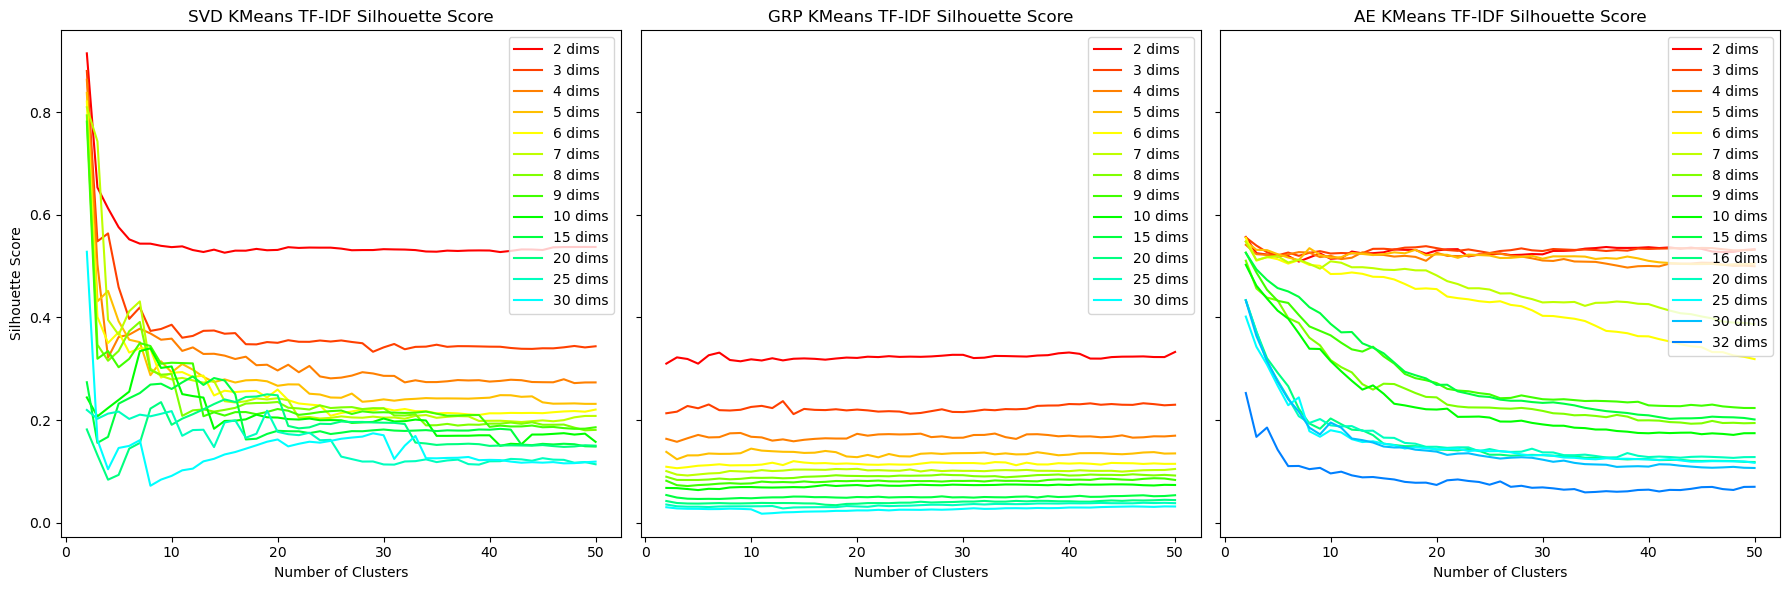

In [339]:
reduction_range_chart = [2,3,4,5,6,7,8,9,10,15,20,25,30]
reduction_range_chart_ae = [2,3,4,5,6,7,8,9,10,15,16,20,25,30,32]

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # Adjust figsize as needed

# First plot
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_svd_k_tfidf[results_svd_k_tfidf['Reduced Dims'] == dimensions]
    axs[0].plot(reduced_results['K'], reduced_results['Silhouette Score'], label=f'{dimensions} dims', color=colors[index])
axs[0].set_title('SVD KMeans TF-IDF Silhouette Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')
axs[0].legend()

# Second plot
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_grp_k_tfidf[results_grp_k_tfidf['Reduced Dims'] == dimensions]
    axs[1].plot(reduced_results['K'], reduced_results['Silhouette Score'], label=f'{dimensions} dims', color=colors[index])
axs[1].set_title('GRP KMeans TF-IDF Silhouette Score')
axs[1].set_xlabel('Number of Clusters')
# axs[1].set_ylabel('Silhouette Score')  # Optional, as y-label is shared
axs[1].legend()

# Third plot
for index, dimensions in enumerate(reduction_range_chart_ae):
    reduced_results = results_ae_k_tfidf[results_ae_k_tfidf['Reduced Dims'] == dimensions]
    axs[2].plot(reduced_results['K'], reduced_results['Silhouette Score'], label=f'{dimensions} dims', color=colors[index])
axs[2].set_title('AE KMeans TF-IDF Silhouette Score')
axs[2].set_xlabel('Number of Clusters')
# axs[2].set_ylabel('Silhouette Score')  # Optional, as y-label is shared
axs[2].legend(loc='upper right')

plt.tight_layout()  # Adjust layout
plt.show()

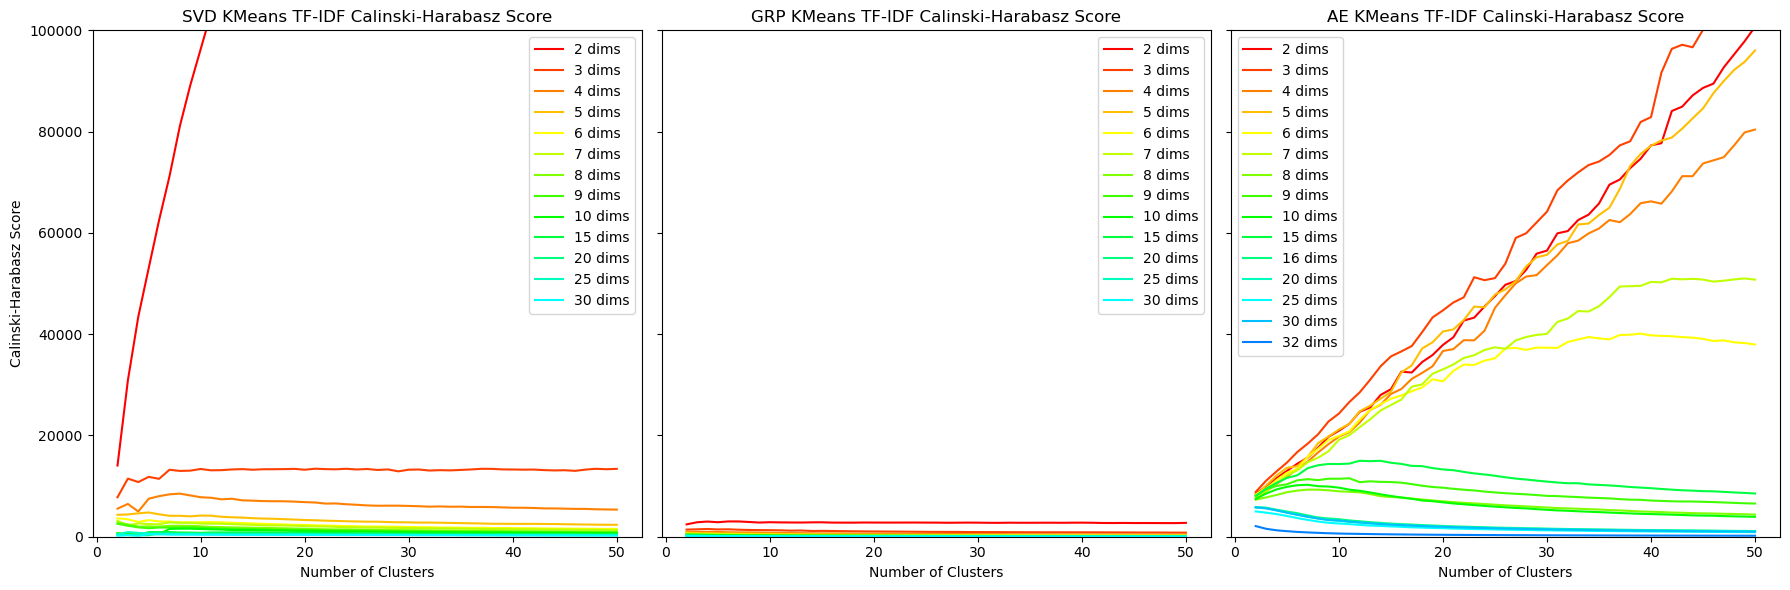

In [314]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # Adjust figsize as needed

# First plot
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_svd_k_tfidf[results_svd_k_tfidf['Reduced Dims'] == dimensions]
    axs[0].plot(reduced_results['K'], reduced_results['Calinski-Harabasz Score'], label=f'{dimensions} dims', color=colors[index])
axs[0].set_title('SVD KMeans TF-IDF Calinski-Harabasz Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Calinski-Harabasz Score')
axs[0].legend()

# Second plot
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_grp_k_tfidf[results_grp_k_tfidf['Reduced Dims'] == dimensions]
    axs[1].plot(reduced_results['K'], reduced_results['Calinski-Harabasz Score'], label=f'{dimensions} dims', color=colors[index])
axs[1].set_title('GRP KMeans TF-IDF Calinski-Harabasz Score')
axs[1].set_xlabel('Number of Clusters')
# axs[1].set_ylabel('Calinski-Harabasz Score')  # Optional, as y-label is shared
axs[1].legend()

# Third plot
for index, dimensions in enumerate(reduction_range_chart_ae):
    reduced_results = results_ae_k_tfidf[results_ae_k_tfidf['Reduced Dims'] == dimensions]
    axs[2].plot(reduced_results['K'], reduced_results['Calinski-Harabasz Score'], label=f'{dimensions} dims', color=colors[index])
axs[2].set_title('AE KMeans TF-IDF Calinski-Harabasz Score')
axs[2].set_xlabel('Number of Clusters')
# axs[2].set_ylabel('Calinski-Harabasz Score')  # Optional, as y-label is shared
axs[2].legend()



axs[0].set_ylim(0, 100000)

plt.tight_layout()  # Adjust layout
plt.show()

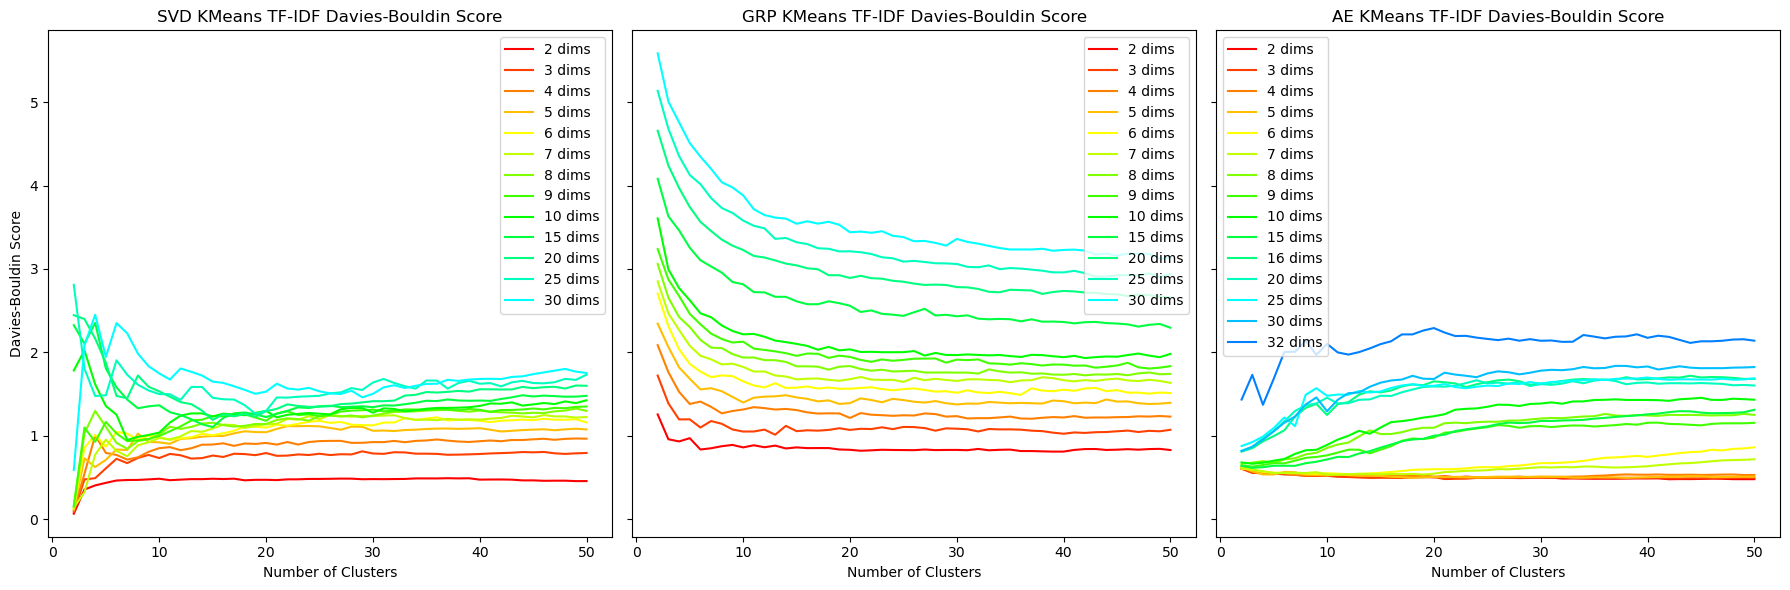

In [292]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # Adjust figsize as needed

# First plot for SVD KMeans TF-IDF Davies-Bouldin Score
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_svd_k_tfidf[results_svd_k_tfidf['Reduced Dims'] == dimensions]
    axs[0].plot(reduced_results['K'], reduced_results['Davies-Bouldin Score'], label=f'{dimensions} dims', color=colors[index])
axs[0].set_title('SVD KMeans TF-IDF Davies-Bouldin Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Davies-Bouldin Score')
axs[0].legend()

# Second plot for GRP KMeans TF-IDF Davies-Bouldin Score
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_grp_k_tfidf[results_grp_k_tfidf['Reduced Dims'] == dimensions]
    axs[1].plot(reduced_results['K'], reduced_results['Davies-Bouldin Score'], label=f'{dimensions} dims', color=colors[index])
axs[1].set_title('GRP KMeans TF-IDF Davies-Bouldin Score')
axs[1].set_xlabel('Number of Clusters')
# axs[1].set_ylabel('Davies-Bouldin Score')  # Optional, as y-label is shared
axs[1].legend()

# Third plot for AE KMeans TF-IDF Davies-Bouldin Score
for index, dimensions in enumerate(reduction_range_chart_ae):
    reduced_results = results_ae_k_tfidf[results_ae_k_tfidf['Reduced Dims'] == dimensions]
    axs[2].plot(reduced_results['K'], reduced_results['Davies-Bouldin Score'], label=f'{dimensions} dims', color=colors[index])
axs[2].set_title('AE KMeans TF-IDF Davies-Bouldin Score')
axs[2].set_xlabel('Number of Clusters')
# axs[2].set_ylabel('Davies-Bouldin Score')  # Optional, as y-label is shared
axs[2].legend()

# Set the same y-axis range for all subplots
all_axs = axs.flatten()
min_ylim = min(ax.get_ylim()[0] for ax in all_axs)
max_ylim = max(ax.get_ylim()[1] for ax in all_axs)
for ax in all_axs:
    ax.set_ylim(min_ylim, max_ylim)

plt.tight_layout()  # Adjust layout
plt.show()

### doc2vec

In [32]:
vectors = doc2vec_vectorize(dataset['Cleaned_Text'])
document_vectors = pd.DataFrame(vectors)
dimension_reduction_range = range(2, 33)
cluster_range = range(2, 51)
results_svd_k_d2v = pd.DataFrame(columns=['Reduced Dims', 'K', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])
results_grp_k_d2v = pd.DataFrame(columns=['Reduced Dims', 'K', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])
results_ae_k_d2v = pd.DataFrame(columns=['Reduced Dims', 'K', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])

for reduced_dims in tqdm(dimension_reduction_range, desc='SVD'):
    reduced_vectors = svd_reduce(document_vectors, n_components=reduced_dims)
    for num_clusters in cluster_range:
        cluster_assignments = kmeans_cluster(reduced_vectors, n_clusters=num_clusters)
        silhouette = silhouette_score(reduced_vectors, cluster_assignments, random_state=42)
        calinski_harabasz = calinski_harabasz_score(reduced_vectors, cluster_assignments)
        davies_bouldin = davies_bouldin_score(reduced_vectors, cluster_assignments)
        results_svd_k_d2v.loc[len(results_svd_k_d2v)] = [reduced_dims, num_clusters, silhouette, calinski_harabasz, davies_bouldin]

for reduced_dims in tqdm(dimension_reduction_range, desc='GRP'):
    reduced_vectors = grp_reduce(document_vectors, n_components=reduced_dims)
    for num_clusters in cluster_range:
        cluster_assignments = kmeans_cluster(reduced_vectors, n_clusters=num_clusters)
        silhouette = silhouette_score(reduced_vectors, cluster_assignments, random_state=42)
        calinski_harabasz = calinski_harabasz_score(reduced_vectors, cluster_assignments)
        davies_bouldin = davies_bouldin_score(reduced_vectors, cluster_assignments)
        results_grp_k_d2v.loc[len(results_grp_k_d2v)] = [reduced_dims, num_clusters, silhouette, calinski_harabasz, davies_bouldin]

for reduced_dims in tqdm(dimension_reduction_range, desc='AE'):
    reduced_vectors = ae_reduce(document_vectors, n_components=reduced_dims)
    for num_clusters in cluster_range:
        cluster_assignments = kmeans_cluster(reduced_vectors, n_clusters=num_clusters)
        silhouette = silhouette_score(reduced_vectors, cluster_assignments, random_state=42)
        calinski_harabasz = calinski_harabasz_score(reduced_vectors, cluster_assignments)
        davies_bouldin = davies_bouldin_score(reduced_vectors, cluster_assignments)
        results_ae_k_d2v.loc[len(results_ae_k_d2v)] = [reduced_dims, num_clusters, silhouette, calinski_harabasz, davies_bouldin]

AE:   0%|          | 0/31 [00:00<?, ?it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step - loss: 0.5693 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step


AE:   3%|▎         | 1/31 [00:14<07:12, 14.40s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 458us/step - loss: 0.4777 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step


AE:   6%|▋         | 2/31 [00:28<06:54, 14.28s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 430us/step - loss: 0.5635 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step


AE:  10%|▉         | 3/31 [00:45<07:13, 15.50s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 556us/step - loss: 0.3679 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


AE:  13%|█▎        | 4/31 [01:02<07:18, 16.25s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step - loss: 0.3414 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


AE:  16%|█▌        | 5/31 [01:17<06:47, 15.66s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 442us/step - loss: 0.2996 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


AE:  19%|█▉        | 6/31 [01:32<06:22, 15.32s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 435us/step - loss: 0.4316 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


AE:  23%|██▎       | 7/31 [01:47<06:08, 15.37s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 525us/step - loss: 0.4686 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step


AE:  26%|██▌       | 8/31 [02:07<06:23, 16.69s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 396us/step - loss: 0.2747 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 288us/step


AE:  29%|██▉       | 9/31 [02:21<05:50, 15.95s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 402us/step - loss: 0.3037 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step


AE:  32%|███▏      | 10/31 [02:36<05:27, 15.58s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 404us/step - loss: 0.4522 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 284us/step


AE:  35%|███▌      | 11/31 [02:51<05:08, 15.43s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step - loss: 0.5073 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


AE:  39%|███▊      | 12/31 [03:09<05:07, 16.17s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 0.5332 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


AE:  42%|████▏     | 13/31 [03:24<04:46, 15.93s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step - loss: 0.5167 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


AE:  45%|████▌     | 14/31 [03:43<04:48, 16.95s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 0.4635 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


AE:  48%|████▊     | 15/31 [04:01<04:34, 17.14s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 399us/step - loss: 0.4647 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 265us/step


AE:  52%|█████▏    | 16/31 [04:19<04:18, 17.26s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step - loss: 0.4991 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 240us/step


AE:  55%|█████▍    | 17/31 [04:39<04:14, 18.15s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step - loss: 0.4692 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


AE:  58%|█████▊    | 18/31 [04:57<03:58, 18.31s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step - loss: 0.4932 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


AE:  61%|██████▏   | 19/31 [05:18<03:48, 19.07s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step - loss: 0.4522 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 242us/step


AE:  65%|██████▍   | 20/31 [05:38<03:30, 19.12s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step - loss: 0.4742 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


AE:  68%|██████▊   | 21/31 [05:52<02:57, 17.73s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step - loss: 0.4251 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step


AE:  71%|███████   | 22/31 [06:07<02:33, 17.02s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step - loss: 0.4263 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


AE:  74%|███████▍  | 23/31 [06:22<02:10, 16.27s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step - loss: 0.4946 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


AE:  77%|███████▋  | 24/31 [06:38<01:52, 16.08s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 364us/step - loss: 0.4245 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 256us/step


AE:  81%|████████  | 25/31 [06:53<01:36, 16.04s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 373us/step - loss: 0.4017 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 269us/step


AE:  84%|████████▍ | 26/31 [07:09<01:18, 15.75s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 347us/step - loss: 0.3841 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


AE:  87%|████████▋ | 27/31 [07:23<01:01, 15.29s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 360us/step - loss: 0.4168 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


AE:  90%|█████████ | 28/31 [07:39<00:46, 15.51s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step - loss: 0.4220 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step


AE:  94%|█████████▎| 29/31 [07:57<00:32, 16.23s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 350us/step - loss: 0.3834 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


AE:  97%|█████████▋| 30/31 [08:14<00:16, 16.49s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 344us/step - loss: 0.3903 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 246us/step


AE: 100%|██████████| 31/31 [08:32<00:00, 16.53s/it]


Charts

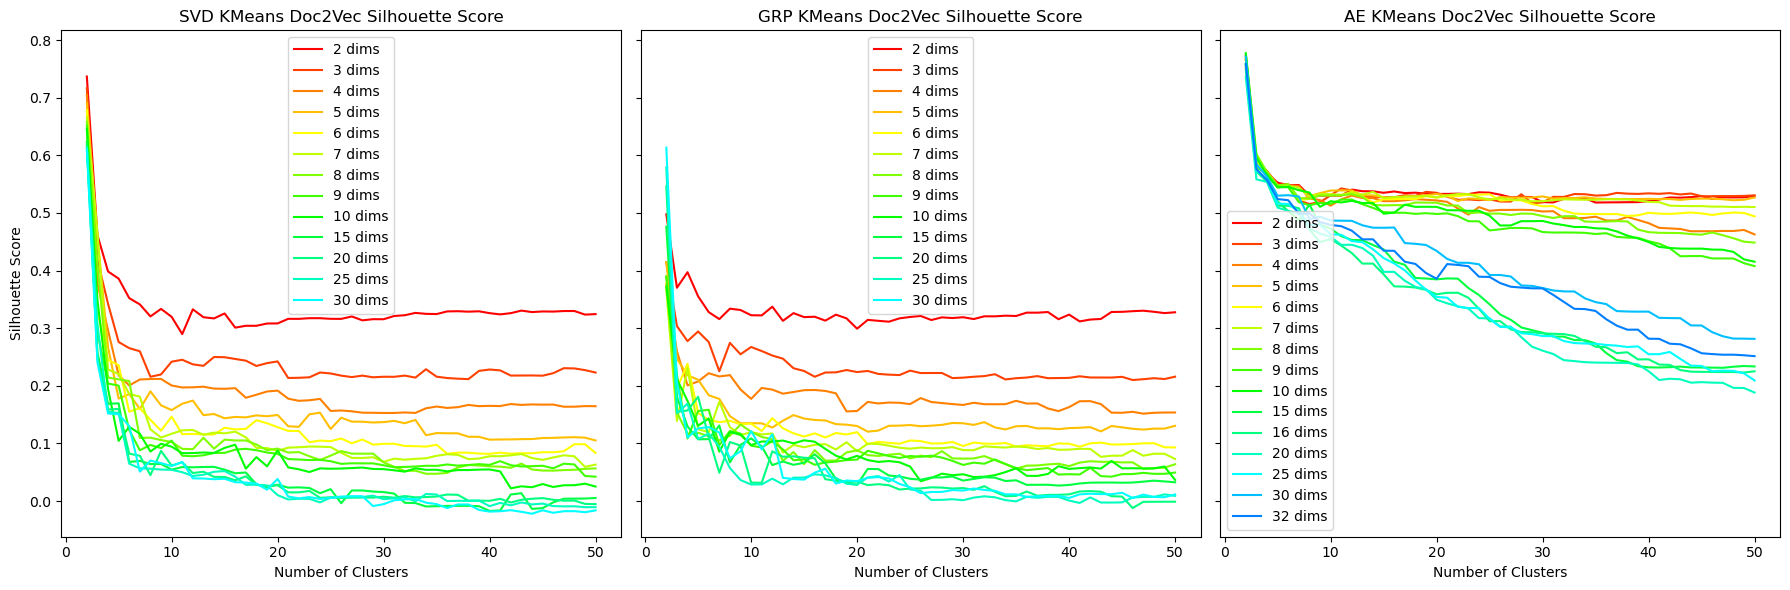

In [340]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # 1 row, 3 columns, shared y-axis

# SVD KMeans Doc2Vec Silhouette Score
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_svd_k_d2v[results_svd_k_d2v['Reduced Dims'] == dimensions]
    axs[0].plot(reduced_results['K'], reduced_results['Silhouette Score'], label=f'{dimensions} dims', color=colors[index])
axs[0].set_title('SVD KMeans Doc2Vec Silhouette Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')
axs[0].legend()

# GRP KMeans Doc2Vec Silhouette Score
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_grp_k_d2v[results_grp_k_d2v['Reduced Dims'] == dimensions]
    axs[1].plot(reduced_results['K'], reduced_results['Silhouette Score'], label=f'{dimensions} dims', color=colors[index])
axs[1].set_title('GRP KMeans Doc2Vec Silhouette Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].legend()
# axs[1].set_ylabel('Silhouette Score')  # Shared Y-axis

# AE KMeans Doc2Vec Silhouette Score
for index, dimensions in enumerate(reduction_range_chart_ae):
    reduced_results = results_ae_k_d2v[results_ae_k_d2v['Reduced Dims'] == dimensions]
    axs[2].plot(reduced_results['K'], reduced_results['Silhouette Score'], label=f'{dimensions} dims', color=colors[index])
axs[2].set_title('AE KMeans Doc2Vec Silhouette Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].legend()
# axs[2].set_ylabel('Silhouette Score')  # Shared Y-axis

plt.tight_layout()
plt.show()

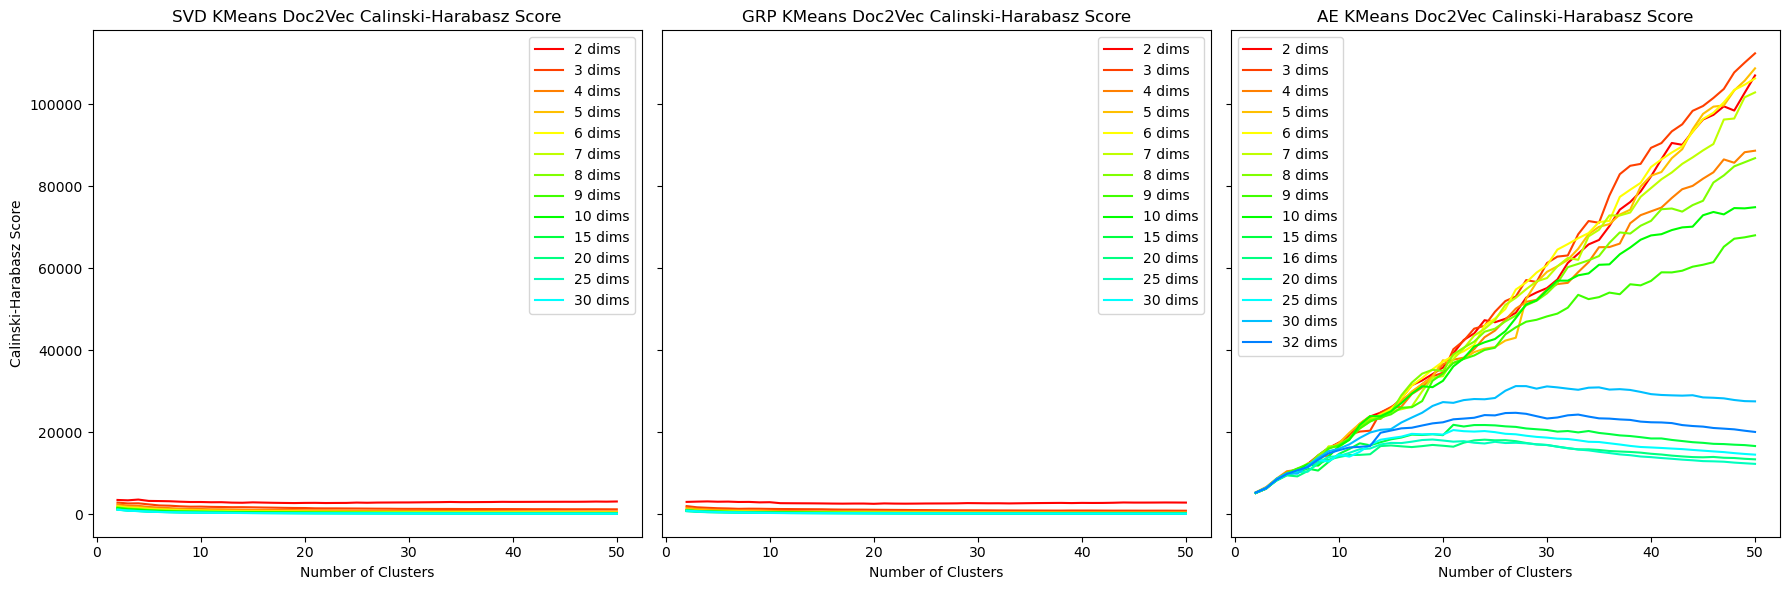

In [341]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # 1 row, 3 columns, shared y-axis

# SVD KMeans Doc2Vec Calinski-Harabasz Score
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_svd_k_d2v[results_svd_k_d2v['Reduced Dims'] == dimensions]
    axs[0].plot(reduced_results['K'], reduced_results['Calinski-Harabasz Score'], label=f'{dimensions} dims', color=colors[index])
axs[0].set_title('SVD KMeans Doc2Vec Calinski-Harabasz Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Calinski-Harabasz Score')
axs[0].legend()

# GRP KMeans Doc2Vec Calinski-Harabasz Score
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_grp_k_d2v[results_grp_k_d2v['Reduced Dims'] == dimensions]
    axs[1].plot(reduced_results['K'], reduced_results['Calinski-Harabasz Score'], label=f'{dimensions} dims', color=colors[index])
axs[1].set_title('GRP KMeans Doc2Vec Calinski-Harabasz Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].legend()
# axs[1].set_ylabel('Calinski-Harabasz Score')  # Shared Y-axis

# AE KMeans Doc2Vec Calinski-Harabasz Score
for index, dimensions in enumerate(reduction_range_chart_ae):
    reduced_results = results_ae_k_d2v[results_ae_k_d2v['Reduced Dims'] == dimensions]
    axs[2].plot(reduced_results['K'], reduced_results['Calinski-Harabasz Score'], label=f'{dimensions} dims', color=colors[index])
axs[2].set_title('AE KMeans Doc2Vec Calinski-Harabasz Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].legend()
# axs[2].set_ylabel('Calinski-Harabasz Score')  # Shared Y-axis

plt.tight_layout()
plt.show()


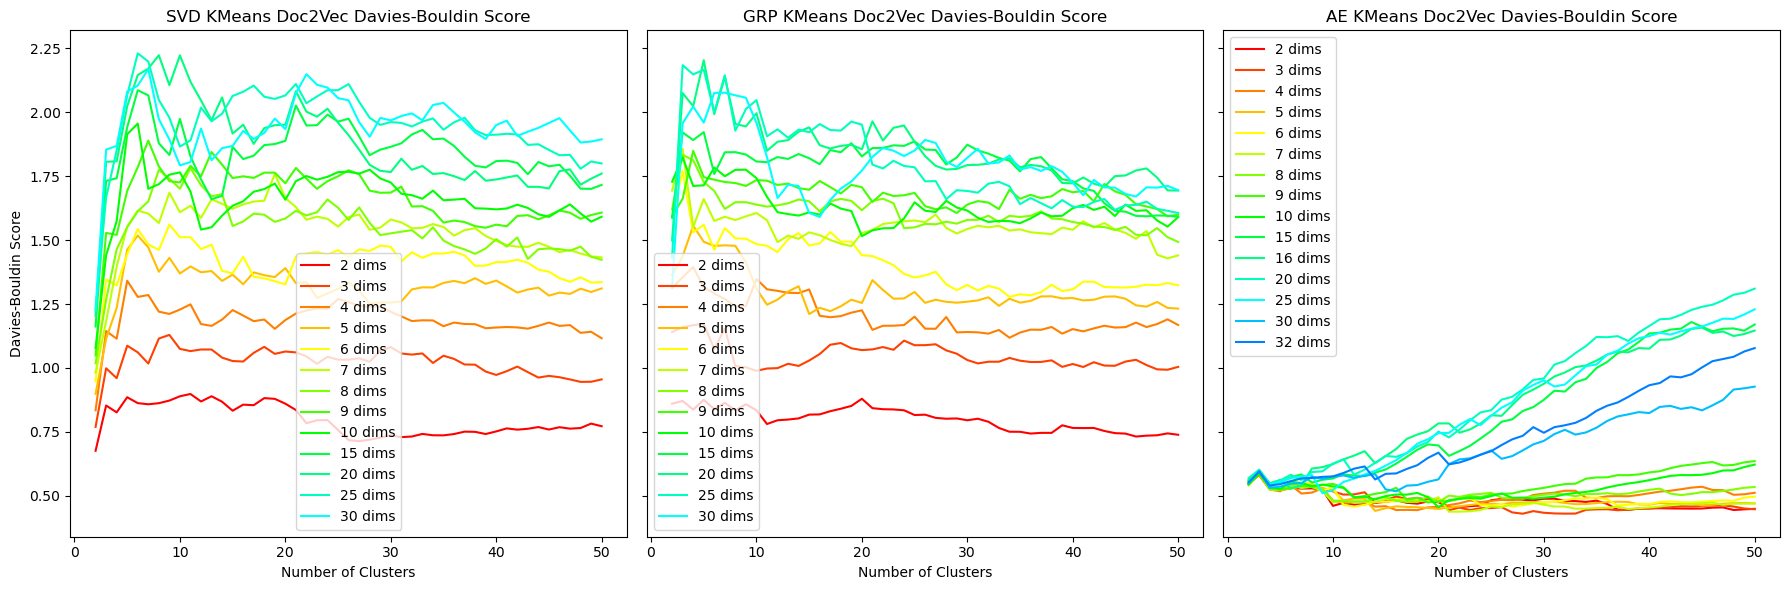

In [342]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # 1 row, 3 columns, shared y-axis

# SVD KMeans Doc2Vec Davies-Bouldin Score
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_svd_k_d2v[results_svd_k_d2v['Reduced Dims'] == dimensions]
    axs[0].plot(reduced_results['K'], reduced_results['Davies-Bouldin Score'], label=f'{dimensions} dims', color=colors[index])
axs[0].set_title('SVD KMeans Doc2Vec Davies-Bouldin Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Davies-Bouldin Score')
axs[0].legend()

# GRP KMeans Doc2Vec Davies-Bouldin Score
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_grp_k_d2v[results_grp_k_d2v['Reduced Dims'] == dimensions]
    axs[1].plot(reduced_results['K'], reduced_results['Davies-Bouldin Score'], label=f'{dimensions} dims', color=colors[index])
axs[1].set_title('GRP KMeans Doc2Vec Davies-Bouldin Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].legend()
# axs[1].set_ylabel('Davies-Bouldin Score')  # Shared Y-axis

# AE KMeans Doc2Vec Davies-Bouldin Score
for index, dimensions in enumerate(reduction_range_chart_ae):
    reduced_results = results_ae_k_d2v[results_ae_k_d2v['Reduced Dims'] == dimensions]
    axs[2].plot(reduced_results['K'], reduced_results['Davies-Bouldin Score'], label=f'{dimensions} dims', color=colors[index])
axs[2].set_title('AE KMeans Doc2Vec Davies-Bouldin Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].legend()
# axs[2].set_ylabel('Davies-Bouldin Score')  # Shared Y-axis

plt.tight_layout()
plt.show()

## GMM

### tfidf

In [37]:
document_vectors = tfidf_vectorize(dataset['Cleaned_Text'])
dimension_reduction_range = range(2, 33)
cluster_range = range(2, 51)
results_svd_gmm_tfidf = pd.DataFrame(columns=['Reduced Dims', 'N components', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])
results_grp_gmm_tfidf = pd.DataFrame(columns=['Reduced Dims', 'N components', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])
results_ae_gmm_tfidf = pd.DataFrame(columns=['Reduced Dims', 'N components', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])

for reduced_dims in tqdm(dimension_reduction_range, desc='SVD'):
    reduced_vectors = svd_reduce(document_vectors, n_components=reduced_dims)
    for num_clusters in cluster_range:
        cluster_assignments = gmm_cluster(reduced_vectors, n_components=num_clusters)
        silhouette = silhouette_score(reduced_vectors, cluster_assignments, random_state=42)
        calinski_harabasz = calinski_harabasz_score(reduced_vectors, cluster_assignments)
        davies_bouldin = davies_bouldin_score(reduced_vectors, cluster_assignments)
        results_svd_gmm_tfidf.loc[len(results_svd_gmm_tfidf)] = [reduced_dims, num_clusters, silhouette, calinski_harabasz, davies_bouldin]

for reduced_dims in tqdm(dimension_reduction_range, desc='GRP'):
    reduced_vectors = grp_reduce(document_vectors, n_components=reduced_dims)
    for num_clusters in cluster_range:
        cluster_assignments = gmm_cluster(reduced_vectors, n_components=num_clusters)
        silhouette = silhouette_score(reduced_vectors, cluster_assignments, random_state=42)
        calinski_harabasz = calinski_harabasz_score(reduced_vectors, cluster_assignments)
        davies_bouldin = davies_bouldin_score(reduced_vectors, cluster_assignments)
        results_grp_gmm_tfidf.loc[len(results_grp_gmm_tfidf)] = [reduced_dims, num_clusters, silhouette, calinski_harabasz, davies_bouldin]

for reduced_dims in tqdm(dimension_reduction_range, desc='AE'):
    reduced_vectors = ae_reduce(document_vectors, n_components=reduced_dims)
    for num_clusters in cluster_range:
        cluster_assignments = gmm_cluster(reduced_vectors, n_components=num_clusters)
        silhouette = silhouette_score(reduced_vectors, cluster_assignments, random_state=42)
        calinski_harabasz = calinski_harabasz_score(reduced_vectors, cluster_assignments)
        davies_bouldin = davies_bouldin_score(reduced_vectors, cluster_assignments)
        results_ae_gmm_tfidf.loc[len(results_ae_gmm_tfidf)] = [reduced_dims, num_clusters, silhouette, calinski_harabasz, davies_bouldin]

AE:   0%|          | 0/31 [00:00<?, ?it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - loss: 0.3957
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step


AE:   3%|▎         | 1/31 [00:23<11:56, 23.89s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - loss: 0.4561
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step


AE:   6%|▋         | 2/31 [00:44<10:38, 22.02s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - loss: 0.4351
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step


AE:  10%|▉         | 3/31 [01:09<10:59, 23.55s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step - loss: 0.4733 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step


AE:  13%|█▎        | 4/31 [01:37<11:17, 25.10s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - loss: 0.4391
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step


AE:  16%|█▌        | 5/31 [02:29<15:02, 34.70s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - loss: 0.4039
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step


AE:  19%|█▉        | 6/31 [03:16<16:17, 39.09s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step - loss: 0.3995 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step


AE:  23%|██▎       | 7/31 [04:58<23:47, 59.47s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 771us/step - loss: 0.4248
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


AE:  26%|██▌       | 8/31 [06:14<24:52, 64.90s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - loss: 0.4000 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step


AE:  29%|██▉       | 9/31 [07:52<27:34, 75.20s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step - loss: 0.3952
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step


AE:  32%|███▏      | 10/31 [10:07<32:45, 93.61s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step - loss: 0.3991 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step


AE:  35%|███▌      | 11/31 [11:16<28:42, 86.14s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 577us/step - loss: 0.4115 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step


AE:  39%|███▊      | 12/31 [13:02<29:10, 92.15s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 549us/step - loss: 0.3970 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step


AE:  42%|████▏     | 13/31 [15:33<33:00, 110.03s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 567us/step - loss: 0.4230 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step


AE:  45%|████▌     | 14/31 [17:55<33:53, 119.60s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 494us/step - loss: 0.4100 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 291us/step


AE:  48%|████▊     | 15/31 [20:58<36:59, 138.71s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 565us/step - loss: 0.4170 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step


AE:  52%|█████▏    | 16/31 [24:14<38:58, 155.92s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 528us/step - loss: 0.4160 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


AE:  55%|█████▍    | 17/31 [27:56<41:00, 175.76s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 612us/step - loss: 0.4020 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step


AE:  58%|█████▊    | 18/31 [31:54<42:08, 194.51s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - loss: 0.4226 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step


AE:  61%|██████▏   | 19/31 [36:49<44:57, 224.76s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 535us/step - loss: 0.4011 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


AE:  65%|██████▍   | 20/31 [41:09<43:06, 235.18s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step - loss: 0.3967
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


AE:  68%|██████▊   | 21/31 [45:20<39:59, 239.99s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 495us/step - loss: 0.3936 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


AE:  71%|███████   | 22/31 [49:10<35:32, 236.93s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 718us/step - loss: 0.4105
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step


AE:  74%|███████▍  | 23/31 [52:47<30:49, 231.22s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - loss: 0.3917
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 293us/step


AE:  77%|███████▋  | 24/31 [58:08<30:05, 257.92s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - loss: 0.3906 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step


AE:  81%|████████  | 25/31 [1:03:09<27:05, 271.00s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 501us/step - loss: 0.3981 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step


AE:  84%|████████▍ | 26/31 [1:08:59<24:33, 294.71s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - loss: 0.4018 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 303us/step


AE:  87%|████████▋ | 27/31 [1:14:32<20:24, 306.07s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - loss: 0.3759 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 297us/step


AE:  90%|█████████ | 28/31 [1:19:14<14:57, 299.01s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 726us/step - loss: 0.3820
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step


AE:  94%|█████████▎| 29/31 [1:24:07<09:54, 297.20s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3998 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step


AE:  97%|█████████▋| 30/31 [1:31:04<05:32, 332.98s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 456us/step - loss: 0.4268 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step


AE: 100%|██████████| 31/31 [1:36:06<00:00, 186.02s/it]


Charts

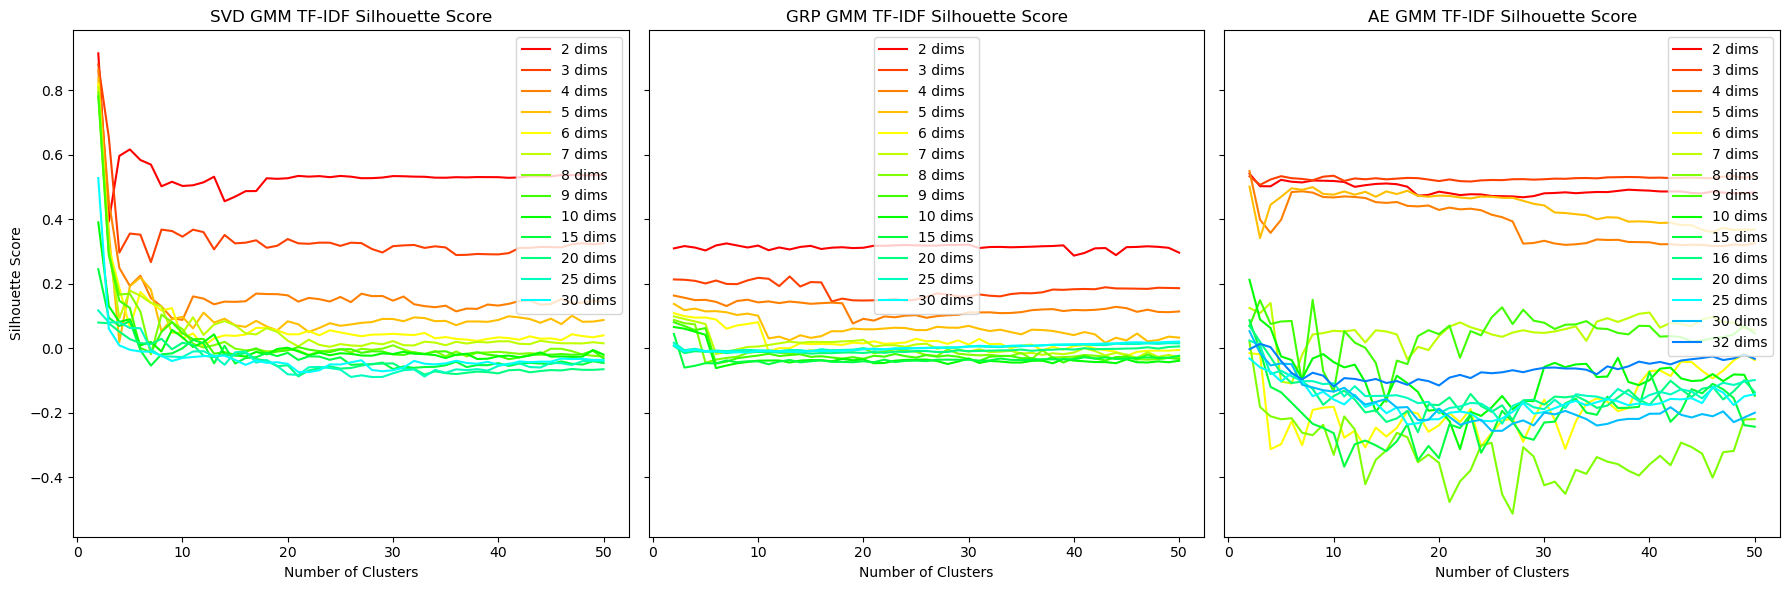

In [343]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # 1 row, 3 columns, shared y-axis

# SVD GMM TF-IDF Silhouette Score
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_svd_gmm_tfidf[results_svd_gmm_tfidf['Reduced Dims'] == dimensions]
    axs[0].plot(reduced_results['N components'], reduced_results['Silhouette Score'], label=f'{dimensions} dims', color=colors[index])
axs[0].set_title('SVD GMM TF-IDF Silhouette Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')
axs[0].legend()

# GRP GMM TF-IDF Silhouette Score
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_grp_gmm_tfidf[results_grp_gmm_tfidf['Reduced Dims'] == dimensions]
    axs[1].plot(reduced_results['N components'], reduced_results['Silhouette Score'], label=f'{dimensions} dims', color=colors[index])
axs[1].set_title('GRP GMM TF-IDF Silhouette Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].legend()
# axs[1].set_ylabel('Silhouette Score')  # Shared Y-axis

# AE GMM TF-IDF Silhouette Score
for index, dimensions in enumerate(reduction_range_chart_ae):
    reduced_results = results_ae_gmm_tfidf[results_ae_gmm_tfidf['Reduced Dims'] == dimensions]
    axs[2].plot(reduced_results['N components'], reduced_results['Silhouette Score'], label=f'{dimensions} dims', color=colors[index])
axs[2].set_title('AE GMM TF-IDF Silhouette Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].legend()
# axs[2].set_ylabel('Silhouette Score')  # Shared Y-axis

plt.tight_layout()
plt.show()

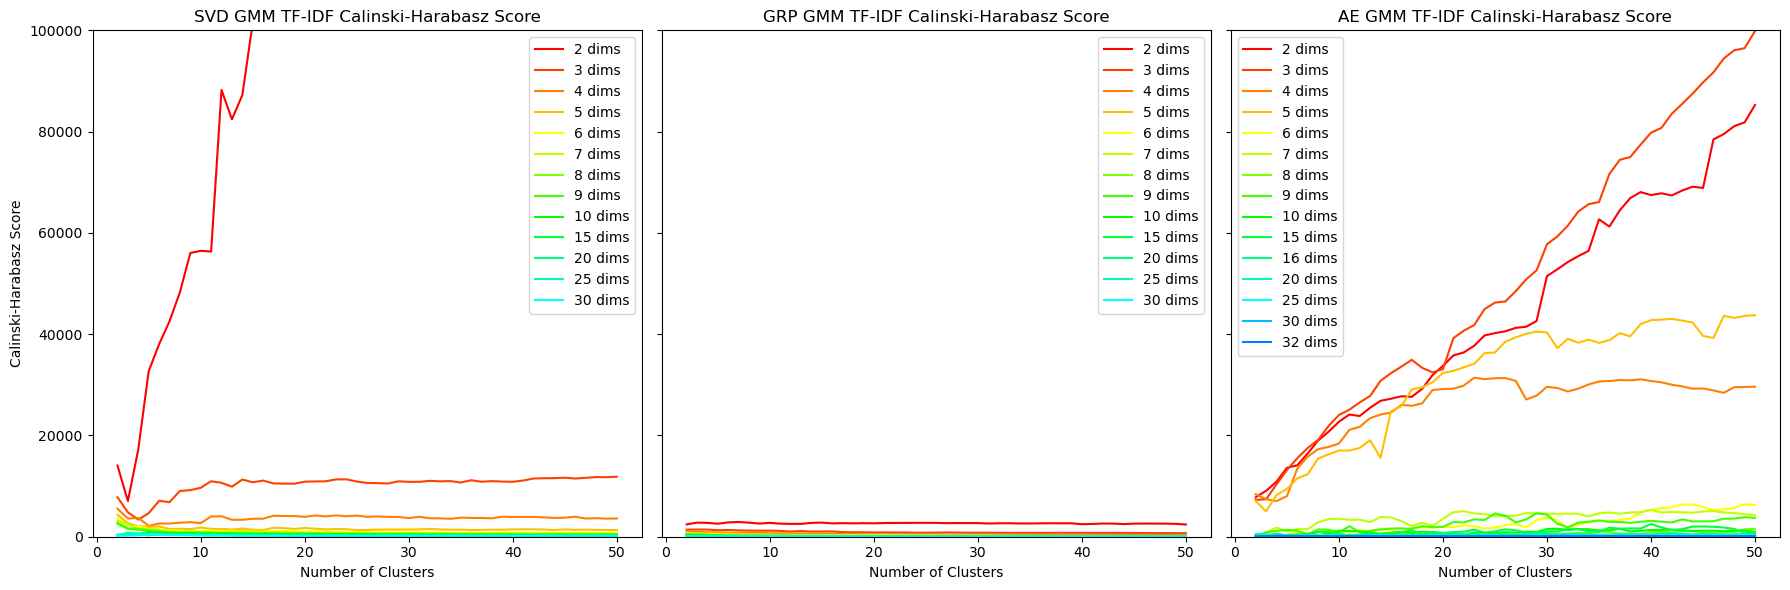

In [344]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # 1 row, 3 columns

# SVD GMM TF-IDF Calinski-Harabasz Score
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_svd_gmm_tfidf[results_svd_gmm_tfidf['Reduced Dims'] == dimensions]
    axs[0].plot(reduced_results['N components'], reduced_results['Calinski-Harabasz Score'], label=f'{dimensions} dims', color=colors[index])
axs[0].set_title('SVD GMM TF-IDF Calinski-Harabasz Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Calinski-Harabasz Score')
axs[0].legend()

# GRP GMM TF-IDF Calinski-Harabasz Score
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_grp_gmm_tfidf[results_grp_gmm_tfidf['Reduced Dims'] == dimensions]
    axs[1].plot(reduced_results['N components'], reduced_results['Calinski-Harabasz Score'], label=f'{dimensions} dims', color=colors[index])
axs[1].set_title('GRP GMM TF-IDF Calinski-Harabasz Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].legend()
# axs[1].set_ylabel('Calinski-Harabasz Score')  # Shared Y-axis

# AE GMM TF-IDF Calinski-Harabasz Score
for index, dimensions in enumerate(reduction_range_chart_ae):
    reduced_results = results_ae_gmm_tfidf[results_ae_gmm_tfidf['Reduced Dims'] == dimensions]
    axs[2].plot(reduced_results['N components'], reduced_results['Calinski-Harabasz Score'], label=f'{dimensions} dims', color=colors[index])
axs[2].set_title('AE GMM TF-IDF Calinski-Harabasz Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].legend()
# axs[2].set_ylabel('Calinski-Harabasz Score')  # Shared Y-axis

axs[0].set_ylim(0, 100000)

plt.tight_layout()
plt.show()

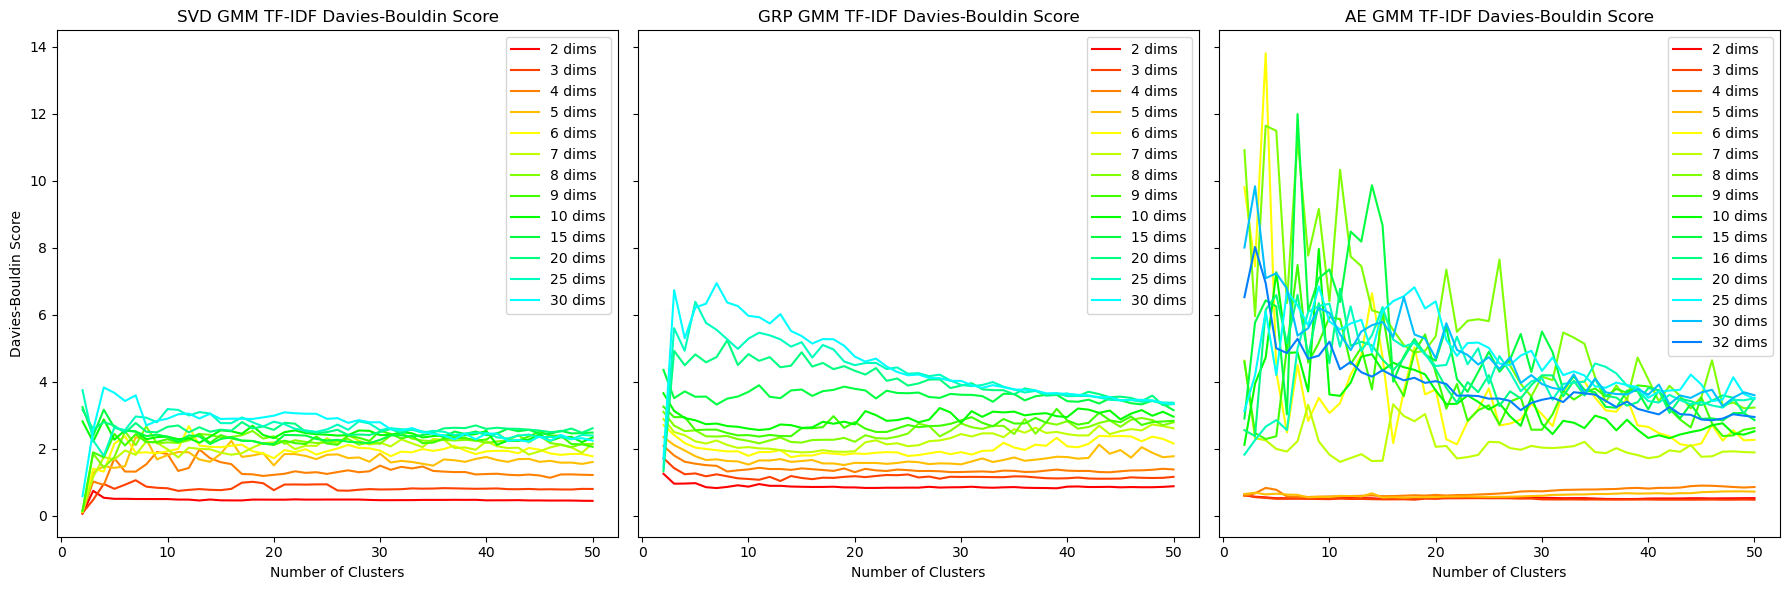

In [345]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # 1 row, 3 columns, shared y-axis

# SVD GMM TF-IDF Davies-Bouldin Score
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_svd_gmm_tfidf[results_svd_gmm_tfidf['Reduced Dims'] == dimensions]
    axs[0].plot(reduced_results['N components'], reduced_results['Davies-Bouldin Score'], label=f'{dimensions} dims', color=colors[index])
axs[0].set_title('SVD GMM TF-IDF Davies-Bouldin Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Davies-Bouldin Score')
axs[0].legend()

# GRP GMM TF-IDF Davies-Bouldin Score
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_grp_gmm_tfidf[results_grp_gmm_tfidf['Reduced Dims'] == dimensions]
    axs[1].plot(reduced_results['N components'], reduced_results['Davies-Bouldin Score'], label=f'{dimensions} dims', color=colors[index])
axs[1].set_title('GRP GMM TF-IDF Davies-Bouldin Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].legend()
# axs[1].set_ylabel('Davies-Bouldin Score')  # Shared Y-axis

# AE GMM TF-IDF Davies-Bouldin Score
for index, dimensions in enumerate(reduction_range_chart_ae):
    reduced_results = results_ae_gmm_tfidf[results_ae_gmm_tfidf['Reduced Dims'] == dimensions]
    axs[2].plot(reduced_results['N components'], reduced_results['Davies-Bouldin Score'], label=f'{dimensions} dims', color=colors[index])
axs[2].set_title('AE GMM TF-IDF Davies-Bouldin Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].legend()
# axs[2].set_ylabel('Davies-Bouldin Score')  # Shared Y-axis

plt.tight_layout()
plt.show()

### doc2vec

In [41]:
vectors = doc2vec_vectorize(dataset['Cleaned_Text'])
document_vectors = pd.DataFrame(vectors)
dimension_reduction_range = range(2, 33)
cluster_range = range(2, 51)
results_svd_gmm_d2v = pd.DataFrame(columns=['Reduced Dims', 'N components', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])
results_grp_gmm_d2v = pd.DataFrame(columns=['Reduced Dims', 'N components', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])
results_ae_gmm_d2v = pd.DataFrame(columns=['Reduced Dims', 'N components', 'Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'])

for reduced_dims in tqdm(dimension_reduction_range, desc='SVD'):
    reduced_vectors = svd_reduce(document_vectors, n_components=reduced_dims)
    for num_clusters in cluster_range:
        cluster_assignments = gmm_cluster(reduced_vectors, n_components=num_clusters)
        silhouette = silhouette_score(reduced_vectors, cluster_assignments, random_state=42)
        calinski_harabasz = calinski_harabasz_score(reduced_vectors, cluster_assignments)
        davies_bouldin = davies_bouldin_score(reduced_vectors, cluster_assignments)
        results_svd_gmm_d2v.loc[len(results_svd_gmm_d2v)] = [reduced_dims, num_clusters, silhouette, calinski_harabasz, davies_bouldin]

for reduced_dims in tqdm(dimension_reduction_range, desc='GRP'):
    reduced_vectors = grp_reduce(document_vectors, n_components=reduced_dims)
    for num_clusters in cluster_range:
        cluster_assignments = gmm_cluster(reduced_vectors, n_components=num_clusters)
        silhouette = silhouette_score(reduced_vectors, cluster_assignments, random_state=42)
        calinski_harabasz = calinski_harabasz_score(reduced_vectors, cluster_assignments)
        davies_bouldin = davies_bouldin_score(reduced_vectors, cluster_assignments)
        results_grp_gmm_d2v.loc[len(results_grp_gmm_d2v)] = [reduced_dims, num_clusters, silhouette, calinski_harabasz, davies_bouldin]

for reduced_dims in tqdm(dimension_reduction_range, desc='AE'):
    reduced_vectors = ae_reduce(document_vectors, n_components=reduced_dims)
    for num_clusters in cluster_range:
        cluster_assignments = gmm_cluster(reduced_vectors, n_components=num_clusters)
        silhouette = silhouette_score(reduced_vectors, cluster_assignments, random_state=42)
        calinski_harabasz = calinski_harabasz_score(reduced_vectors, cluster_assignments)
        davies_bouldin = davies_bouldin_score(reduced_vectors, cluster_assignments)
        results_ae_gmm_d2v.loc[len(results_ae_gmm_d2v)] = [reduced_dims, num_clusters, silhouette, calinski_harabasz, davies_bouldin]

AE:   0%|          | 0/31 [00:00<?, ?it/s]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - loss: 0.5502 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step


AE:   3%|▎         | 1/31 [00:19<09:52, 19.75s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 437us/step - loss: 0.5355 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step


AE:   6%|▋         | 2/31 [00:47<11:46, 24.35s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 464us/step - loss: 0.4561 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step


AE:  10%|▉         | 3/31 [01:23<13:49, 29.61s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step - loss: 0.4068 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step


AE:  13%|█▎        | 4/31 [02:04<15:19, 34.06s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 393us/step - loss: 0.5047 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


AE:  16%|█▌        | 5/31 [02:50<16:44, 38.63s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step - loss: 0.5377 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step


AE:  19%|█▉        | 6/31 [03:23<15:18, 36.72s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 403us/step - loss: 0.3819 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 279us/step


AE:  23%|██▎       | 7/31 [04:53<21:37, 54.04s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 394us/step - loss: 0.3426 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


AE:  26%|██▌       | 8/31 [06:51<28:33, 74.51s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 387us/step - loss: 0.5037 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step


AE:  29%|██▉       | 9/31 [09:07<34:17, 93.52s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 396us/step - loss: 0.4431 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step


AE:  32%|███▏      | 10/31 [11:41<39:18, 112.31s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 411us/step - loss: 0.2870 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 286us/step


AE:  35%|███▌      | 11/31 [13:47<38:49, 116.48s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 341us/step - loss: 0.5060 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


AE:  39%|███▊      | 12/31 [16:10<39:26, 124.56s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 367us/step - loss: 0.4964 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


AE:  42%|████▏     | 13/31 [18:59<41:21, 137.87s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 340us/step - loss: 0.5088 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


AE:  45%|████▌     | 14/31 [21:13<38:45, 136.77s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 340us/step - loss: 0.4106 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


AE:  48%|████▊     | 15/31 [24:21<40:36, 152.31s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 358us/step - loss: 0.5085 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step


AE:  52%|█████▏    | 16/31 [27:29<40:47, 163.16s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 376us/step - loss: 0.5024 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


AE:  55%|█████▍    | 17/31 [30:05<37:32, 160.92s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 352us/step - loss: 0.5052 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 267us/step


AE:  58%|█████▊    | 18/31 [33:21<37:09, 171.47s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 340us/step - loss: 0.5207 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


AE:  61%|██████▏   | 19/31 [37:17<38:10, 190.89s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 378us/step - loss: 0.4657 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step


AE:  65%|██████▍   | 20/31 [42:00<40:02, 218.45s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 338us/step - loss: 0.4342 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


AE:  68%|██████▊   | 21/31 [44:50<33:57, 203.79s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 335us/step - loss: 0.4983 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


AE:  71%|███████   | 22/31 [47:36<28:52, 192.52s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 371us/step - loss: 0.4984 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 268us/step


AE:  74%|███████▍  | 23/31 [52:46<30:21, 227.68s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 387us/step - loss: 0.4662 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


AE:  77%|███████▋  | 24/31 [55:52<25:06, 215.21s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 350us/step - loss: 0.4909 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


AE:  81%|████████  | 25/31 [59:29<21:34, 215.82s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 353us/step - loss: 0.5026 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


AE:  84%|████████▍ | 26/31 [1:02:43<17:26, 209.34s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 376us/step - loss: 0.3630 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 257us/step


AE:  87%|████████▋ | 27/31 [1:05:39<13:16, 199.17s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 372us/step - loss: 0.4274 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 270us/step


AE:  90%|█████████ | 28/31 [1:08:46<09:47, 195.72s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 368us/step - loss: 0.3858 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step


AE:  94%|█████████▎| 29/31 [1:13:17<07:16, 218.09s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 349us/step - loss: 0.3921 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 263us/step


AE:  97%|█████████▋| 30/31 [1:16:46<03:35, 215.44s/it]

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 389us/step - loss: 0.4032 
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 264us/step


AE: 100%|██████████| 31/31 [1:21:11<00:00, 157.13s/it]


Charts

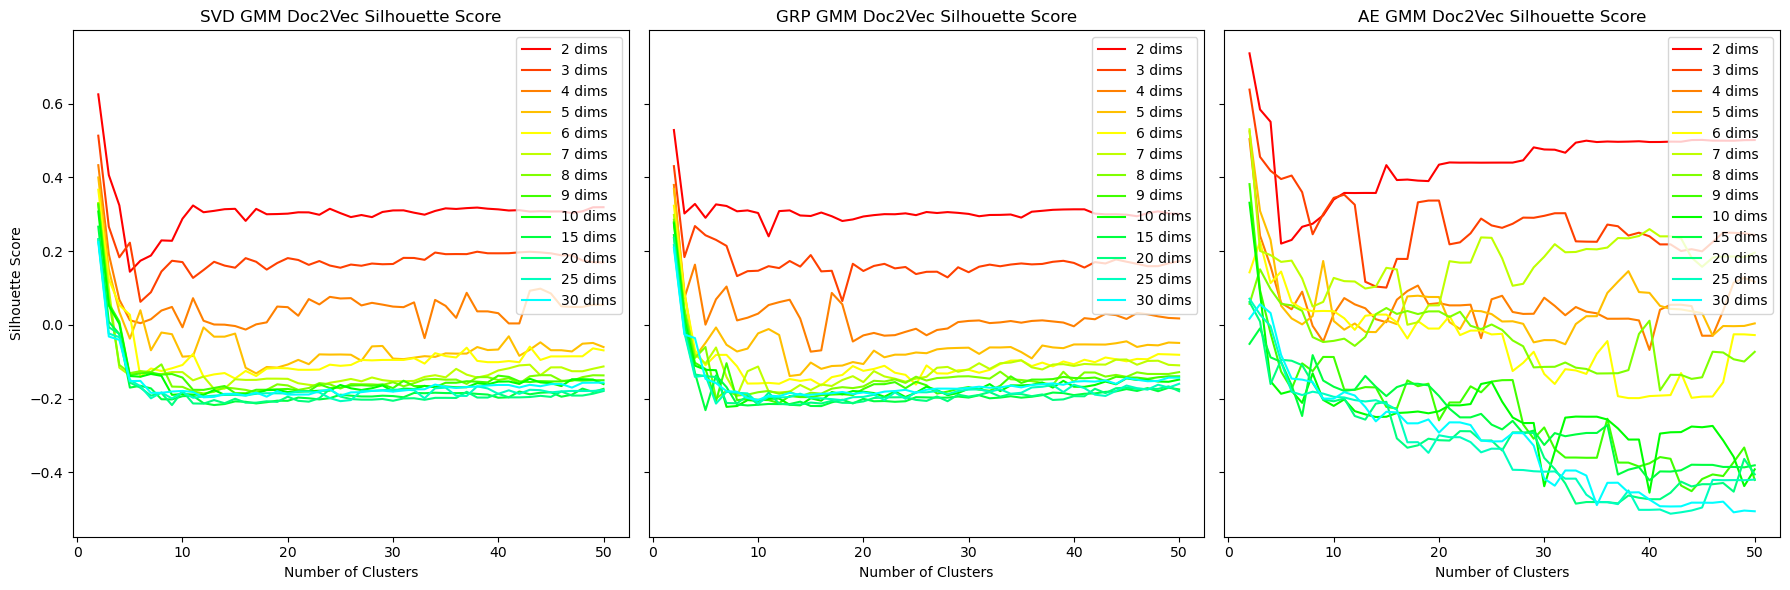

In [346]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)  # 1 row, 3 columns, shared y-axis

# SVD GMM Doc2Vec Silhouette Score
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_svd_gmm_d2v[results_svd_gmm_d2v['Reduced Dims'] == dimensions]
    axs[0].plot(reduced_results['N components'], reduced_results['Silhouette Score'], label=f'{dimensions} dims', color=colors[index])
axs[0].set_title('SVD GMM Doc2Vec Silhouette Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')
axs[0].legend()

# GRP GMM Doc2Vec Silhouette Score
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_grp_gmm_d2v[results_grp_gmm_d2v['Reduced Dims'] == dimensions]
    axs[1].plot(reduced_results['N components'], reduced_results['Silhouette Score'], label=f'{dimensions} dims', color=colors[index])
axs[1].set_title('GRP GMM Doc2Vec Silhouette Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].legend()
# axs[1].set_ylabel('Silhouette Score')  # Shared Y-axis

# AE GMM Doc2Vec Silhouette Score
for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_ae_gmm_d2v[results_ae_gmm_d2v['Reduced Dims'] == dimensions]
    axs[2].plot(reduced_results['N components'], reduced_results['Silhouette Score'], label=f'{dimensions} dims', color=colors[index])
axs[2].set_title('AE GMM Doc2Vec Silhouette Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].legend()
# axs[2].set_ylabel('Silhouette Score')  # Shared Y-axis

plt.tight_layout()
plt.show()

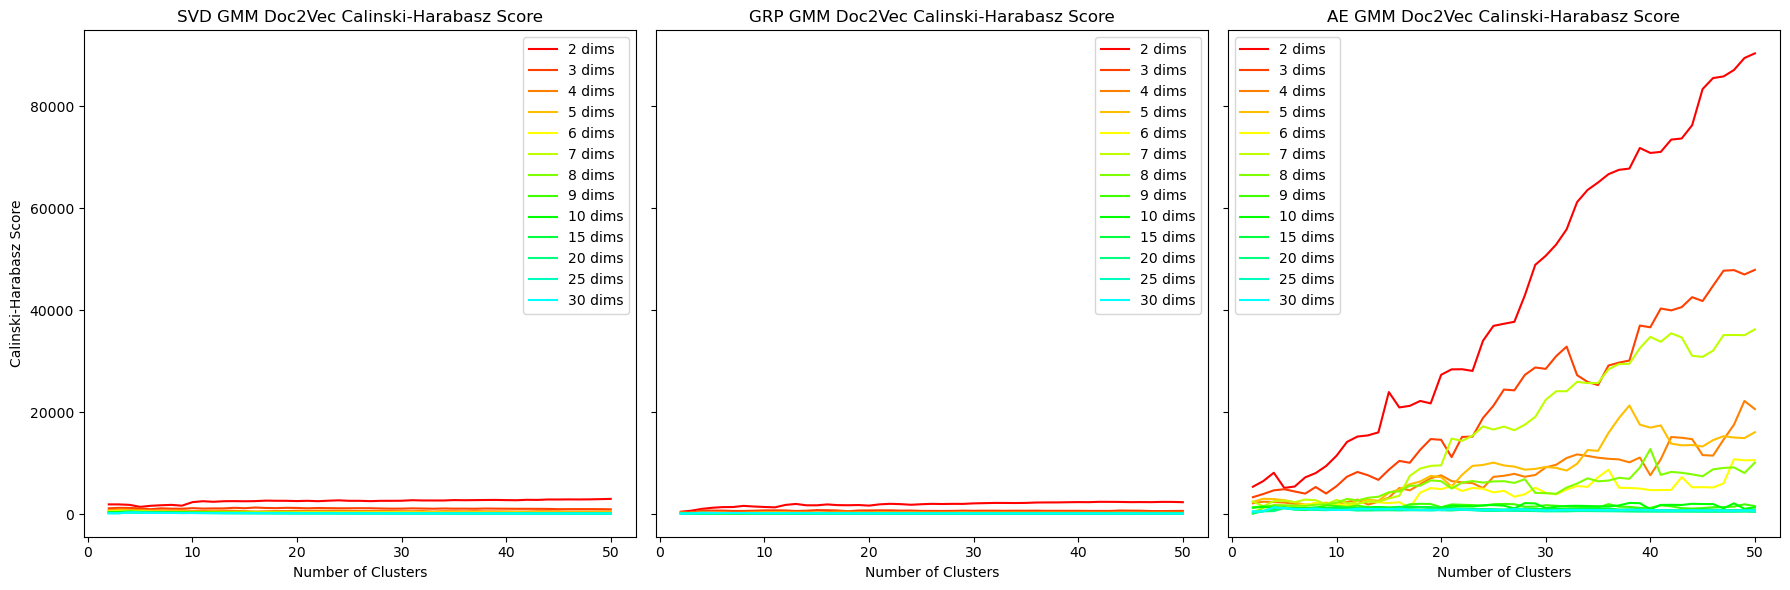

In [347]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_svd_gmm_d2v[results_svd_gmm_d2v['Reduced Dims'] == dimensions]
    axs[0].plot(reduced_results['N components'], reduced_results['Calinski-Harabasz Score'], label=f'{dimensions} dims', color=colors[index])
axs[0].set_title('SVD GMM Doc2Vec Calinski-Harabasz Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Calinski-Harabasz Score')
axs[0].legend()

for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_grp_gmm_d2v[results_grp_gmm_d2v['Reduced Dims'] == dimensions]
    axs[1].plot(reduced_results['N components'], reduced_results['Calinski-Harabasz Score'], label=f'{dimensions} dims', color=colors[index])
axs[1].set_title('GRP GMM Doc2Vec Calinski-Harabasz Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].legend()
# axs[1].set_ylabel('Calinski-Harabasz Score')  # Shared Y-axis

for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_ae_gmm_d2v[results_ae_gmm_d2v['Reduced Dims'] == dimensions]
    axs[2].plot(reduced_results['N components'], reduced_results['Calinski-Harabasz Score'], label=f'{dimensions} dims', color=colors[index])
axs[2].set_title('AE GMM Doc2Vec Calinski-Harabasz Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].legend()
# axs[2].set_ylabel('Calinski-Harabasz Score')  # Shared Y-axis

plt.tight_layout()
plt.show()

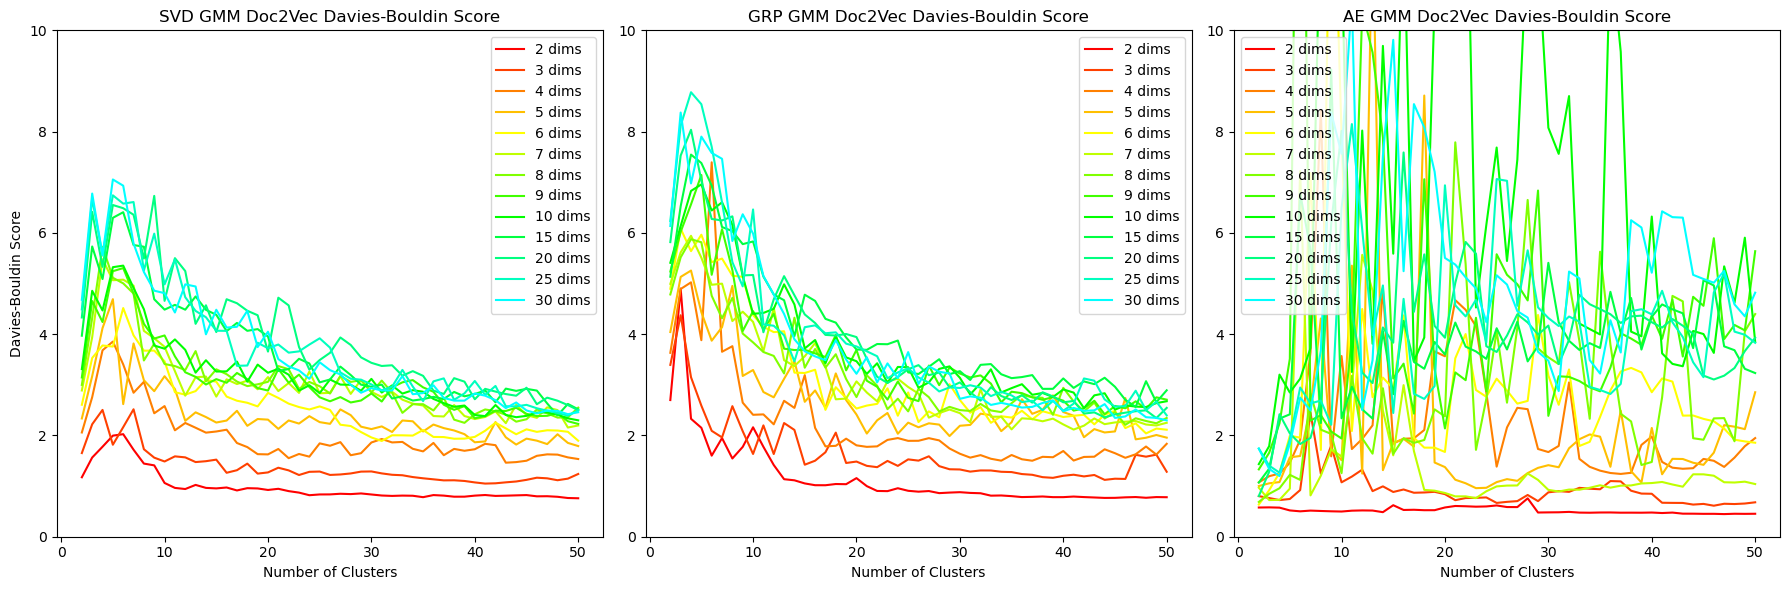

In [348]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_svd_gmm_d2v[results_svd_gmm_d2v['Reduced Dims'] == dimensions]
    axs[0].plot(reduced_results['N components'], reduced_results['Davies-Bouldin Score'], label=f'{dimensions} dims', color=colors[index])
axs[0].set_title('SVD GMM Doc2Vec Davies-Bouldin Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Davies-Bouldin Score')
axs[0].legend()

for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_grp_gmm_d2v[results_grp_gmm_d2v['Reduced Dims'] == dimensions]
    axs[1].plot(reduced_results['N components'], reduced_results['Davies-Bouldin Score'], label=f'{dimensions} dims', color=colors[index])
axs[1].set_title('GRP GMM Doc2Vec Davies-Bouldin Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].legend()
# axs[1].set_ylabel('Davies-Bouldin Score')  # Shared Y-axis

for index, dimensions in enumerate(reduction_range_chart):
    reduced_results = results_ae_gmm_d2v[results_ae_gmm_d2v['Reduced Dims'] == dimensions]
    axs[2].plot(reduced_results['N components'], reduced_results['Davies-Bouldin Score'], label=f'{dimensions} dims', color=colors[index])
axs[2].set_title('AE GMM Doc2Vec Davies-Bouldin Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].legend()
# axs[2].set_ylabel('Davies-Bouldin Score')  # Shared Y-axis

all_axs = axs.flatten()
min_ylim = 0
max_ylim = 10
for ax in all_axs:
    ax.set_ylim(min_ylim, max_ylim)

plt.tight_layout()
plt.show()

## DBSCAN

In [207]:
document_vectors = tfidf_vectorize(dataset['Cleaned_Text'])
reduced_vectors = svd_reduce(document_vectors, n_components=5)

By changing the value of eps on the first line it can be seen how the cluster 0 starts containing 100% of the data for values >= 0.008 and by decrementing this value, the cluster 0 becomes smaller and more entries are added to cluster -1 which represents the noise cluster until most entries are consider to be noise for very low values. This was tested using difference distance metrics, different vectorization and dimension reduction techniques and the result was alwasy the same scenario, with the values of eps changing depinding on the configuration.

Number of clusters: 1


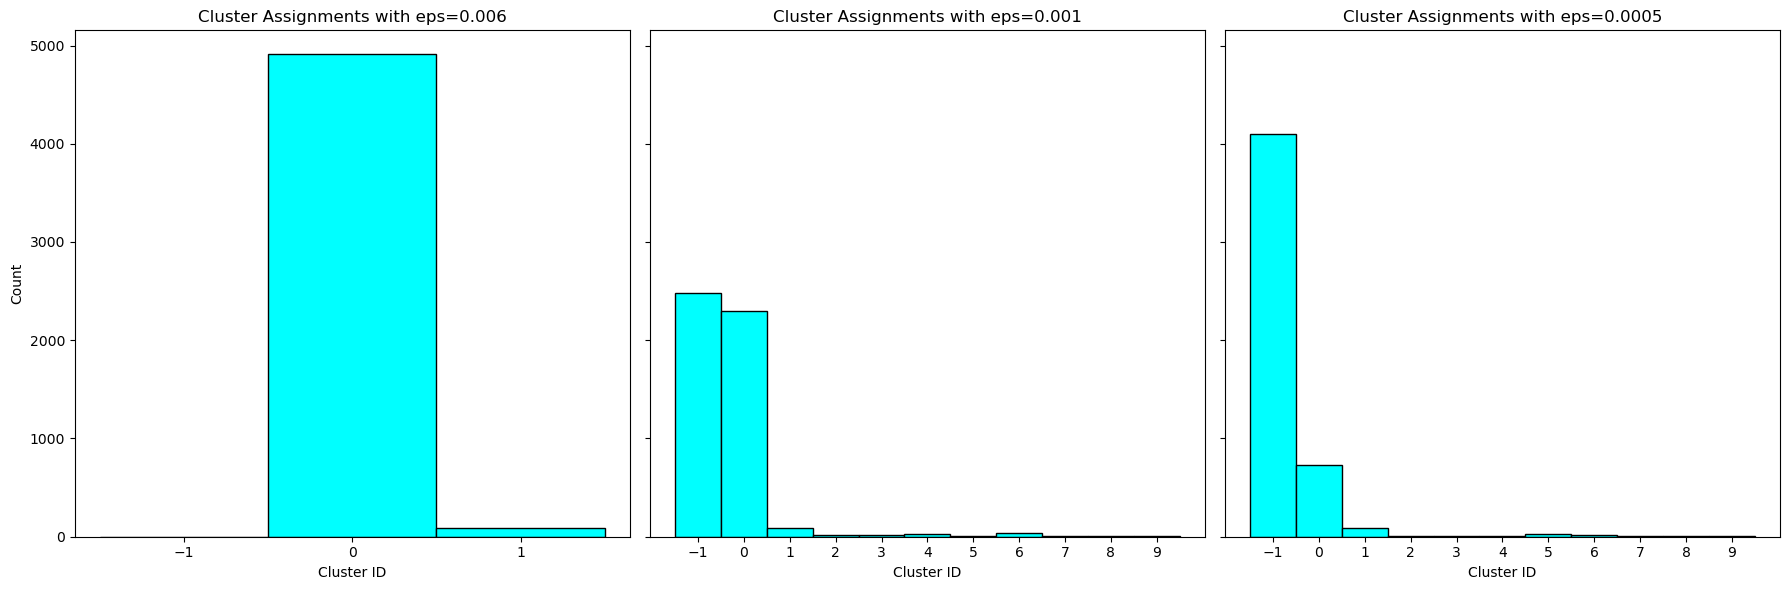

In [359]:

cluster_assignments_a = dbscan_cluster(reduced_vectors, eps=0.006, metric=DistanceMetric.COSINE.value)
cluster_assignments_b = dbscan_cluster(reduced_vectors, eps=0.001, metric=DistanceMetric.COSINE.value)
cluster_assignments_c = dbscan_cluster(reduced_vectors, eps=0.0005, metric=DistanceMetric.COSINE.value)
print('Number of clusters:', max(cluster_assignments) + 1)
 
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

axs[0].hist(cluster_assignments_a, bins=range(min(cluster_assignments_a), max(cluster_assignments_a) + 2), align='left', color='cyan', edgecolor='black')
axs[0].set_title('Cluster Assignments with eps=0.006')
axs[0].set_xlabel('Cluster ID')
axs[0].set_ylabel('Count')
axs[0].set_xticks(range(min(cluster_assignments_a), max(cluster_assignments_a) + 1))

axs[1].hist(cluster_assignments_b, bins=range(min(cluster_assignments_b), max(cluster_assignments_b) + 2), align='left', color='cyan', edgecolor='black')
axs[1].set_title('Cluster Assignments with eps=0.001')
axs[1].set_xlabel('Cluster ID')
# axs[1].set_ylabel('Count')  # Shared Y-axis
axs[1].set_xticks(range(min(cluster_assignments_b), max(cluster_assignments_b) + 1))

axs[2].hist(cluster_assignments_c, bins=range(min(cluster_assignments_c), max(cluster_assignments_c) + 2), align='left', color='cyan', edgecolor='black')
axs[2].set_title('Cluster Assignments with eps=0.0005')
axs[2].set_xlabel('Cluster ID')
# axs[2].set_ylabel('Count')  # Shared Y-axis
axs[2].set_xticks(range(min(cluster_assignments_c), max(cluster_assignments_c) + 1))

plt.tight_layout()
plt.show()

# Best Algorithm

The best number of clusters is still to be defined since it completely depends on the complete dataset. For the rest of the experiment a number of 25 clusters will be used but it can simple be changed by changing the cluster_number value at the beginning. 

In [211]:
cluster_number = 25
document_vectors = tfidf_vectorize(dataset['Cleaned_Text'])
reduced_vectors = svd_reduce(document_vectors, n_components=5)
cluster_assignments = kmeans_cluster(reduced_vectors, n_clusters=cluster_number)

silhouette = silhouette_score(reduced_vectors, cluster_assignments, random_state=0)
calinski_Harabasz = calinski_harabasz_score(reduced_vectors, cluster_assignments)

print('Silhouette score:', silhouette)
print('Calinski-Harabasz score:', calinski_Harabasz)

for i in range(0, cluster_number):
    print('Cluster', i, 'has', len(cluster_assignments[cluster_assignments == i]), 'documents')

Silhouette score: 0.24410196412953322
Calinski-Harabasz score: 3012.7412356339605
Cluster 0 has 192 documents
Cluster 1 has 90 documents
Cluster 2 has 668 documents
Cluster 3 has 31 documents
Cluster 4 has 67 documents
Cluster 5 has 98 documents
Cluster 6 has 94 documents
Cluster 7 has 254 documents
Cluster 8 has 53 documents
Cluster 9 has 117 documents
Cluster 10 has 442 documents
Cluster 11 has 70 documents
Cluster 12 has 89 documents
Cluster 13 has 222 documents
Cluster 14 has 29 documents
Cluster 15 has 205 documents
Cluster 16 has 408 documents
Cluster 17 has 116 documents
Cluster 18 has 269 documents
Cluster 19 has 256 documents
Cluster 20 has 66 documents
Cluster 21 has 190 documents
Cluster 22 has 140 documents
Cluster 23 has 120 documents
Cluster 24 has 714 documents


Choosing clusters based on size, not picking the largest ones, analyzing cluster 3, 4 and 5. To check different clusters just change the value of k on the first line.

In [229]:
k = 3

centroids = get_centroids(reduced_vectors, cluster_number)

k_centroid = centroids[k]

indices_in_k = np.nonzero(cluster_assignments == k)

embeddings_in_k = reduced_vectors[indices_in_k]

distances_to_k_centroid = cdist([k_centroid], embeddings_in_k, 'euclidean').flatten()

sorted_indices = np.argsort(distances_to_k_centroid)

sorted_documents_indices = indices_in_k[0][sorted_indices]  

assert max(sorted_documents_indices) < len(dataset), "Index out of range."

sorted_documents = [dataset.iloc[i] for i in sorted_documents_indices]

sorted_documents_df = pd.DataFrame(sorted_documents)

pd.set_option('display.max_colwidth', None)

display(sorted_documents_df.head(5)[['Cleaned_Text']].style.set_properties(**{'text-align': 'left'}))

,Cleaned_Text
37716,crash outliner closing mailnews window close mailnews window reading news crashed outliner stack trace eecc nsoutlinerbodyframedestroy line nsframelistdestroyframes line nscontainerframedestroy line nsboxframedestroy line bytes nsframelistdestroyframes line nscontainerframedestroy line nsboxframedestroy line bytes nsframelistdestroyframes line nscontainerframedestroy line nsboxframedestroy line bytes nsframelistdestroyframes line nscontainerframedestroy line nsboxframedestroy line bytes nsframelistdestroyframes line nscontainerframedestroy line nsboxframedestroy line bytes nsframelistdestroyframes line nscontainerframedestroy line nsboxframedestroy line bytes nsframelistdestroyframes line nscontainerframedestroy line nsboxframedestroy line bytes nsframelistdestroyframes line nscontainerframedestroy line nsboxframedestroy line bytes nsframelistdestroyframes line nscontainerframedestroy line viewportframedestroy line bytes framemanagerdestroy line presshellpresshell line presshellscalar deleting destructor bytes documentviewerimplrelease line bytes nscomptrbaseassignwithaddref line nswebshelldestroy line nsxulwindowdestroy line nscomptrbasenscomptrbase line nswebshellwindowdestroy line bytes appshell const nswebshellwindownsibasewindow address xb nswebshellwindowaddref line nsxulwindowgetprimarycontentshell line fresh build cvs
22324,crash cancelling http authentication go site requires http authentication one typically use scopus well enter information click cancel crash occurs offending line line nshttpchannelcpp namley point userbuf points null array guess fix change first line line bytes nshttpchannelprocessauthentication line bytes nshttpchannelprocessstatuscode line bytes nshttpchannelfinishedresponseheaders line bytes nshttpserverlistenerfinishedresponseheaders line bytes nshttpserverlistenerondataavailable line bytes nsondataavailableeventhandleevent line bytes nsstreamlistenereventhandleplevent line bytes plhandleevent line bytes plprocesspendingevents line bytes mdeventreceiverproc line bytes user e
73010,null entry editor type makewindoweditable results crash mozilla b mozilla gecko build instructions testembed httplxrmozillaorgseamonkeysourceembeddingqatestembedreadmetxt pass null nsnull aeditortype nsieditingsessionmakewindoweditable launch embedding app select makewindoweditable test result unhandled exception crash crashing nseditingsessioncpp line stack trace strcmp line nseditingsessionmakewindoweditable line bytes cnsieditsessionmakewinedittest line bytes cnsieditsessiononstarttests line ctestsoninterfacesnsieditingsession line afxdispatchcmdmsg xaff ctestsoninterfacesnsieditingsession x unsigned afxcmdhandlerinfo x line ccmdtargetoncmdmsg line bytes ctestsoncmdmsg line cbrowserviewoncmdmsg line bytes cbrowserframeoncmdmsg line bytes cwndoncommand line cframewndoncommand line cwndonwndmsg line bytes cwndwindowproc line bytes afxcallwndproc line bytes afxwndproc line afxwndprocbase line bytes user e
3057,namespace problem html content xul apprunner crashing loading dialog containing table makes imposible editor dialog work heres sample xul test heres stack ntdll f nsdebugassertion line bytes rdfxulbuilderimpladdattribute line bytes rdfxulbuilderimplcreatehtmlelement line bytes rdfxulbuilderimplcreateelement line bytes rdfxulbuilderimplappendchild line bytes rdfxulbuilderimplcreatecontents line bytes xuldocumentimplcreatecontents line bytes rdfelementimplensurecontentsgenerated line bytes rdfelementimplchildcount line bytes nscssframeconstructorprocesschildren line nscssframeconstructorconstructdocelementframe line nscssframeconstructorcontentinserted line stylesetimplcontentinserted line presshellinitialreflow line
20787,crash nstextboxframecalctextsize crashed resizing message list mail window nstextboxframecalctextsize aboxlayoutstatemreflowstate null nstextboxframecalctextsize line bytes nstextboxframegetprefsize line nssprocketlayoutgetprefsize line nscontainerboxgetprefsize line bytes ns

Cluster 3 relates entries about crashes

In [234]:
k = 4

centroids = get_centroids(reduced_vectors, cluster_number)

k_centroid = centroids[k]

indices_in_k = np.nonzero(cluster_assignments == k)

embeddings_in_k = reduced_vectors[indices_in_k]

distances_to_k_centroid = cdist([k_centroid], embeddings_in_k, 'euclidean').flatten()

sorted_indices = np.argsort(distances_to_k_centroid)

sorted_documents_indices = indices_in_k[0][sorted_indices]  

assert max(sorted_documents_indices) < len(dataset), "Index out of range."

sorted_documents = [dataset.iloc[i] for i in sorted_documents_indices]

sorted_documents_df = pd.DataFrame(sorted_documents)

pd.set_option('display.max_colwidth', None)

display(sorted_documents_df.head(5)[['Cleaned_Text']].style.set_properties(**{'text-align': 'left'}))

,Cleaned_Text
75235,error loading left menu wwwnasdaqcom useragent mozilla gecko build identifier mozilla gecko works fine netscape cant load left menu mozilla reproducible always steps reproduce load page actual results error openning left menu seems error layer frame layer divocmenbdivocmenu expected results loaded menu correctly
75389,freeze loading extremly long hebrew html page useragent mozilla gecko build identifier mozilla gecko page message board exremly large instead loading page mozilla attempts load stopps respoinding possible open another windowtabacees ui switch mozilla running dual g mb ram fast adsl connection horsepower view page reproducible always steps reproduce go url httpwwwhaayalcoilstoryphpidforceskinlogical actual results mozilla freezes attempting load long page expected results mozilla sshould freeze
86060,wwwntfsorg opening useragent mozilla gecko build identifier mozilla gecko table problem think reproducible always steps reproduce go wwwntfsorg actual results page opens table way wide although seems open correctly loading
75199,nonsense displayed aspnet site returns image useragent mozilla gecko build identifier mozilla gecko aspnet page performs action like bitmapsave codebehind browser ie displays image mozilla mozilla displays mass characters behind actual page reproducible always steps reproduce see details actual results mozilla displays lot nonsense characters expected results mozilla display simply image
88404,accessing wwwaimscopecom causes browser crash useragent build identifier mozilla gecko trying access wwwaimscopecom mozilla closes warning indication seems happen soon page accessed anything displayed screen page open konqueror reproducible always steps reproduce open mozilla type wwwaimscopecom location box actual results mozilla shuts expected results page viewed dont get information happens


Cluster 4 relates to issues where the user agent was using the mozilla gecko engine

In [237]:
k = 5

centroids = get_centroids(reduced_vectors, cluster_number)

k_centroid = centroids[k]

indices_in_k = np.nonzero(cluster_assignments == k)

embeddings_in_k = reduced_vectors[indices_in_k]

distances_to_k_centroid = cdist([k_centroid], embeddings_in_k, 'euclidean').flatten()

sorted_indices = np.argsort(distances_to_k_centroid)

sorted_documents_indices = indices_in_k[0][sorted_indices]  

assert max(sorted_documents_indices) < len(dataset), "Index out of range."

sorted_documents = [dataset.iloc[i] for i in sorted_documents_indices]

sorted_documents_df = pd.DataFrame(sorted_documents)

pd.set_option('display.max_colwidth', None)

display(sorted_documents_df.head(5)[['Cleaned_Text']].style.set_properties(**{'text-align': 'left'}))

,Cleaned_Text
122027,domparserparsefromstring greasemonkey script causes assertion inner window greasemonkey script parsefromstring makes firefox assert nsdocumentsetscripthandlingobject assertion inner window win winisinnerwindow file usersjrudermantrunkmozillacontentbasesrcnsdocumentcpp line assertion added bug noticed bug valid xhtml user script triggers im using firefox trunk mac greasemonkey
4859,assertion fails using purify nt astatus variable initialised doesnt seem matter normally run purify gets initial value garbage eventually assertion fails layoutxulbasesrcnsboxframecpp line nsassertion bad status solution initialize astatus created
104129,assertion nsalloc size size updated trunk build get assertion clicking submit button testcase assertion nsalloc size size file cmozillamozillaxpcombase nsmemoryimplcpp line dont get debug build weeks earlier
180058,abort file geckoipcchromiumsrcbasepicklecc line created attachment callstack scenario writedatatype functions pickle hooked use abnormal values let know need information
128462,assertion nswyciwygchannelgetoriginaluri moriginaluri set created attachment stack mozilla gecko minefieldbpre found automated global topsite test httpwwwimdbcomrilinkhpbotbuckethttpwwwavclubcomcontentfeaturexsandosandvsandysone assertion nswyciwygchannelgetoriginaluri moriginaluri set moriginaluri muri file cworkmozillabuildstracemallocmozillacontenthtmldocumentsrcnswyciwygchannelcpp line


Cluster 5 relates to entries about assertions 